# Strategies Codes

# Strategy 1

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import matplotlib.pyplot as plt

# Local min-max strategy with Machine Learning

In this turning point strategy, we will find the local minimum or local maximum using machine learning, then buy when it is a local minimum and selling when it is a local maximum, else holding your position until you hit the next local minimum or maximum. 

Steps in creating machine learning process:
- Preprocess
- Feature Engineering
- Model fitting
- Model evaluation
- Fine tuning


### Import statement
Load the stock price data into memory and remove NA values.

In [2]:
data = pd.read_csv("tr_eikon_eod_data.csv")

### Preprocess the data 

In [3]:
aapl = data["AAPL.O"].dropna().reset_index(drop = True)
msft = data["MSFT.O"].dropna().reset_index(drop = True)
intc = data["INTC.O"].dropna().reset_index(drop = True)
amzn = data["AMZN.O"].dropna().reset_index(drop = True)
gs = data["GS.N"].dropna().reset_index(drop = True)

stock_list = [aapl, msft, intc, amzn, gs]
stock_name_list = ["AAPL.O", "MSFT.O", "INTC.O", "AMZN.O", "GS.N"]

For simplicity, we will work with 1 dataset first: AAPL.O

Strategy:
Finding local minimum points and local maximum points through computation of gradient.

Feature needed:
- The difference between current day gradient and previous day gradient (using np.gradient)

Label generated:
- 1 if gradient crosses zero line from positive value
- -1 if gradient crosses zero line from negative value
- 0 otherwise

In [4]:
def getFeatures(data):
    gradient = np.gradient(data)

    return pd.Series(gradient) - pd.Series(gradient).shift(1)

def generateLabel(data):
    gradient = np.gradient(data)
    label = np.zeros_like(gradient)

    for i in range(1, len(gradient)):
        if gradient[i] == 0:
            if gradient[(i - 1)] > 0:
                label[i] = -1
            else:
                label[i] = 1
        else:
            if gradient[i] > 0 and gradient[i - 1] < 0:
                label[i] = 1
            elif gradient[i] < 0 and gradient[i - 1] > 0:
                label[i] = -1
            else:
                label[i] = 0

    return pd.Series(label)

Combining features and labels together to facilitate easy dropping of newly introduced NaN values.

In [5]:
temp = pd.concat((getFeatures(aapl), generateLabel(aapl)), axis = 1, ignore_index=True).dropna().reset_index(drop=True)

Sequentially splitting data into 80% training and 20% testing

In [6]:
def sequential_split(x, y, train_set=.8):
    threshold = round(train_set * len(x))

    return x[:threshold], x[threshold:], y[:threshold], y[threshold:]


x_train, x_test, y_train, y_test = sequential_split(temp.iloc[:, :-1], temp.iloc[:, -1], .8)

Decide on LogisticRegression as our machine learning model for classification problem.

In [7]:
model = sklearn.linear_model.LogisticRegression()

model.fit(x_train, y_train)

LogisticRegression()

Obtain a prediction for test data set.

In [8]:
y_pred = model.predict(x_test)

Generate classification report to evaluate the model based on precision, recall, accuracy and macro f1-score.

In [9]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.51      0.42      0.46        71
         0.0       0.75      0.81      0.78       285
         1.0       0.57      0.49      0.53        71

    accuracy                           0.69       427
   macro avg       0.61      0.57      0.59       427
weighted avg       0.68      0.69      0.68       427



Generate confusion matrix to visualize performance of model

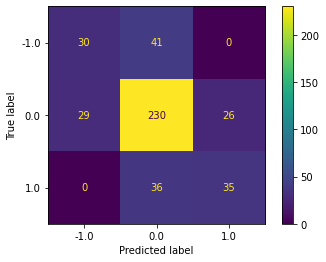

In [10]:
cm = (sklearn.metrics.confusion_matrix(y_test, y_pred))

disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)
disp.plot()
plt.show()

### Evaluation metrics

##### Trading Strategy Metrics

1. Base Profit

    - The total profit generated by a trading strategy with respect to the initial capital.
    

2. Annualized Return

    - The average rate of return per year, calculated as the geometric mean of the cumulative returns.


3. Annualized Volatility	

    - The standard deviation of the daily returns of a trading strategy, annualized by multiplying by the square root of the number of trading days in a year (typically 252).


4. Sharpe Ratio	

    - A measure of risk-adjusted return, calculated as the ratio of the excess return (return above the risk-free rate) to the volatility of the strategy's returns.


5. Max Drawdown	

    - The maximum loss from a peak to a trough of a portfolio, before a new peak is attained.


6. Calmar Ratio	

    - The ratio of the annualized return of a trading strategy to its maximum drawdown, used to assess risk-adjusted performance.


7. Profit diff in ML (vs MR)

    - The difference in profit between a machine learning (ML) based trading strategy and a mean reversion (MR) trading strategy on the test dataset.



In [11]:
# Clean_up_call is removing calls that are not acted upon. Thus keeping only the buying and selling pairs.
def clean_up_call(call):
    called = False
    
    for i in range(len(call)):
        if call[i] == 1:
            if called:
                call[i] = 0
            else:
                called = True
                
        elif call[i] == -1:
            if called:
                called = False
            else:
                call[i] = 0
                
    return call

def simulate(call, data, capital = 100000):
    stocks = 0
    profit = capital

    for i in range(len(call)):
        if call[i] == 1 and capital > data[i + 1]:
            stocks += profit // data[i + 1]
            profit = profit % data[i + 1]
        elif call[i] == -1 and stocks > 0:
            new_profit = data[i + 1] * stocks
            profit += new_profit
            stocks = 0
 
    return ((profit + (stocks * data.iloc[-1]))/ capital) - 1

def evaluate_metrics(call, data, dataname, capital = 100000, risk_free_rate = 0,):
    shares = 0
    df = pd.DataFrame()

    base_wealth = capital + shares * data[0]

    df['current'] = 0

    for i in range(len(data)):
        curr_price = data[i]

        if i < len(call):
            # 'Buy all' : Buy as many shares as possible
            if call[i - 1] == 1 and capital >= curr_price:
                share = capital // curr_price
                shares += share
                capital -= share * curr_price

            # 'Sell all' : Sell all shares held
            elif call[i - 1] == -1 and shares > 0:
                capital += shares * curr_price
                shares = 0

        # Calculate current wealth
        df = pd.concat((df, pd.DataFrame({'current': (shares * curr_price) + capital}, index = [0])), ignore_index=True)

    # Percentage growth of current wealth with respect to the base wealth 
    df['profit_accum'] = (df['current'] - base_wealth) / base_wealth
    # Percentage growth of current wealth with respect to the previous wealth
    df['profit_lag1'] = df['current'].diff() / df['current'].shift(1)

    temp = {}
        
    temp['Base Profit'] = df['profit_accum'].iloc[-1]
    temp['Annualized Return'] = np.prod(1 + df['profit_lag1'])**(252 / len(df)) - 1
    temp['Annualized Volatility'] = np.std(df['profit_lag1']) * np.sqrt(252)
    temp['Sharpe Ratio'] = (temp['Annualized Return'] - risk_free_rate) / temp['Annualized Volatility']

    cum_returns = np.cumprod(1 + df['profit_lag1'][~df['profit_lag1'].isnull()])
    peak = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns - peak) / peak
    temp['Max Drawdown'] = np.min(drawdowns)

    temp['Calmar Ratio'] = temp['Annualized Return'] / abs(temp['Max Drawdown'])

    # Store calculated metrics in the overall metrics dictionary
    display(pd.DataFrame(temp, index = [dataname]))
    
    return df['profit_accum'].iloc[-1]

def showTrades(call, data, graphname = ""):
    pixel_size = 15
    label = "Stock price of {}".format(graphname)
    plt.plot(data, color='grey', label = label)

    buy = [[], []]
    sell = [[], []]

    for i in range(len(call)):
        if call[i] == 1:
            buy[0].append(i)
            buy[1].append(data[i])
        elif call[i] == -1:
            sell[0].append(i)
            sell[1].append(data[i])

    plt.scatter(buy[0], buy[1], s = pixel_size, color = 'g', label = 'buy')
    plt.scatter(sell[0], sell[1], s = pixel_size, color = 'r', label = 'sell')
    plt.title("Buy and sell points from model")
    plt.legend()

    plt.show()

def findProfit(data, dataname, graph = False):
    model = sklearn.linear_model.LogisticRegression()

    threshold = .8
    
    training_data = pd.concat((getFeatures(data), generateLabel(data)), axis = 1, ignore_index=True).dropna().reset_index(drop=True)

    x_train, x_test , y_train, y_test = sequential_split(training_data.iloc[:, :-1], training_data.iloc[:, -1], threshold)

    model.fit(x_train, y_train)

    call = model.predict(x_test)
    
    mets = sklearn.metrics.classification_report(y_test, call, output_dict=True, zero_division=1)
    accuracy = mets['accuracy']
    precision = {key: value['precision'] for key, value in dict(list(mets.items())[:3]).items() if 'precision' in value}

    results = []

    for i in range(10):
        results.append(simulate(call, data[int(round(threshold * len(data))):].reset_index(drop=True)))

    evaluate_metrics(call, data[int(round(threshold * len(data))):].reset_index(drop=True), dataname)
        
    if graph:
        showTrades(clean_up_call(call), data[int(round(threshold * len(data))):].reset_index(drop=True), dataname)
    
    return (np.mean(results) * 100), accuracy, precision


--- For the basic model ---


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,1.804559,0.835253,0.14154,5.901196,-0.06088,13.719754


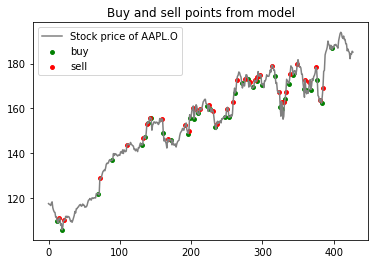

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,2.523972,1.099348,0.13988,7.859202,-0.023345,47.09203


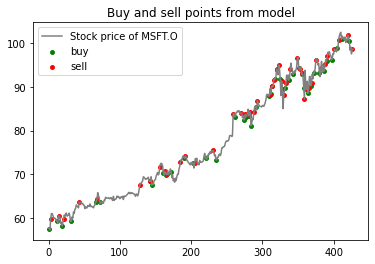

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,2.298004,1.01901,0.178808,5.698909,-0.067433,15.11154


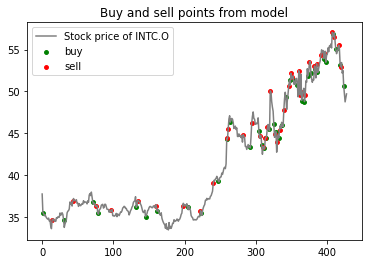

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,4.822722,1.821596,0.181761,10.021932,-0.077695,23.445381


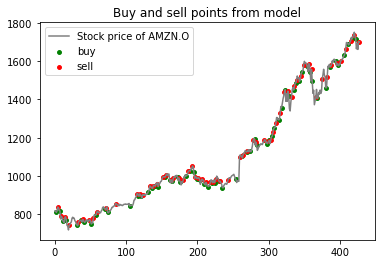

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,2.536753,1.103828,0.14233,7.755404,-0.037387,29.524367


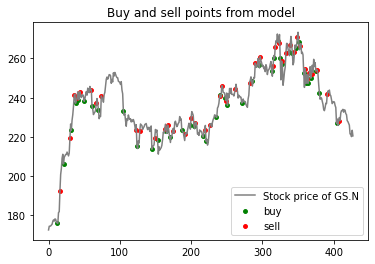

In [12]:
print("\n--- For the basic model ---")

for i in range(len(stock_list)):
    findProfit(stock_list[i], stock_name_list[i], graph = True)


# Enhancement of model

Things changed
1. Added MACD 
2. Added RSI 
3. Trained the model based on the best training data out of the 5 
4. If the prediction of the model is lower than a selected probability, do not act on it

In [13]:
def getMACD(data, short_window=12, long_window=26):
    short_ema = data.ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data.ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=9, min_periods=1, adjust=False).mean()
    
    return macd_line - signal_line

def getRSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def getEnhancedFeatures(data):
    gradient = np.gradient(data)
    grad_diff = pd.Series(gradient) - pd.Series(gradient).shift(1)
    macd = getMACD(data)
    rsi = getRSI(data)

    return pd.concat((grad_diff, macd, rsi), axis = 1)

def generateEnhancedLabel(data):
    gradient = np.gradient(data)
    rsi = getRSI(data)
    rsi_call = np.where((rsi > 50) & (rsi < 70), 1, np.where((rsi > 30) & (rsi < 50), -1, 0))
    macd = getMACD(data)
    
    gradient_call = np.zeros_like(gradient)

    for i in range(1, len(gradient)):
        if gradient[i] == 0:
            if gradient[(i - 1)] > 0:
                gradient_call[i] = -1
            else:
                gradient_call[i] = 1
        else:
            if gradient[i] > 0 and gradient[i - 1] < 0:
                gradient_call[i] = 1
            elif gradient[i] < 0 and gradient[i - 1] > 0:
                gradient_call[i] = -1
            else:
                gradient_call[i] = 0

    macd_call = np.zeros_like(macd)

    for i in range(1, len(macd)):
        if macd[i] == 0:
            if macd[(i - 1)] > 0:
                macd_call[i] = -1
            else:
                macd_call[i] = 1
        else:
            if macd[i] > 0 and macd[i - 1] < 0:
                macd_call[i] = 1
            elif macd[i] < 0 and macd[i - 1] > 0:
                macd_call[i] = -1
            else:
                macd_call[i] = 0

    label = []
    for i in range(len(rsi_call)):
        call = rsi_call[i] + gradient_call[i] + macd_call[i]
        if call > 0:
            label.append(1)
        elif call < 0:
            label.append(-1)
        else:
            label.append(0)
    
    return pd.Series(label)

Testing model on enhanced features.

In [14]:
e_data = aapl

featureWithLabel = pd.concat((getEnhancedFeatures(e_data), generateEnhancedLabel(e_data)), axis = 1).dropna().reset_index(drop=True)
featureWithLabel.columns = ["grad_diff", "macd_diff", "rsi", "label"]
e_x_train, e_x_test, e_y_train, e_y_test = sequential_split(featureWithLabel.iloc[:, :-1], featureWithLabel.iloc[:,-1])

enhancedModel = sklearn.linear_model.LogisticRegression(max_iter = 5000)

enhancedModel.fit(e_x_train, e_y_train)

# predict while ignoring values that model does not confidently predict

def selective_pred(enhancedModel, x_test, y_test):
    prob_pred = enhancedModel.predict_proba(x_test)
    y_pred = []

    for prob in prob_pred:
        if max(prob) >= 0.5:
            y_pred.append(enhancedModel.classes_[list(prob).index(max(prob))])
        else:
            y_pred.append(0)
            
    mets = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    accuracy = mets['accuracy']
    precision = {key: value['precision'] for key, value in dict(list(mets.items())[:3]).items() if 'precision' in value}
    
    return y_pred, accuracy, precision

e_y_pred = selective_pred(enhancedModel, e_x_test, e_y_test)[0]

In [15]:

print(sklearn.metrics.classification_report(e_y_test, e_y_pred))

              precision    recall  f1-score   support

          -1       0.54      0.44      0.49       115
           0       0.32      0.62      0.43       144
           1       0.55      0.19      0.28       166

    accuracy                           0.40       425
   macro avg       0.47      0.42      0.40       425
weighted avg       0.47      0.40      0.38       425



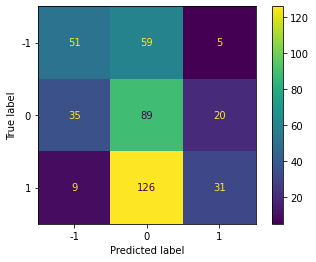

In [16]:
enhanced_cm = sklearn.metrics.confusion_matrix(e_y_test, e_y_pred)
enhanced_disp = sklearn.metrics.ConfusionMatrixDisplay(enhanced_cm, display_labels=enhancedModel.classes_)
enhanced_disp.plot()
plt.show()

In [17]:
# Clean_up_call is removing calls that are not acted upon. Thus keeping only the buying and selling pairs.

def clean_up_call(call):
    called = False
    
    for i in range(len(call)):
        if call[i] == 1:
            if called:
                call[i] = 0
            else:
                called = True
                
        elif call[i] == -1:
            if called:
                called = False
            else:
                call[i] = 0
                
    return call

def findEnhancedProfit(data, train, dataname, graph = False):
    model = sklearn.linear_model.LogisticRegression(max_iter = 5000)

    threshold = .8
    
    training_data = pd.concat((getEnhancedFeatures(train), generateEnhancedLabel(train)), axis = 1, ignore_index=True).dropna().reset_index(drop=True)

    # Unsure if still need sequential_split if working data is different from training data
    x_train, _ , y_train, _ = sequential_split(training_data.iloc[:, :-1], training_data.iloc[:, -1], threshold)

    model.fit(x_train, y_train)

    working_data = pd.concat((getEnhancedFeatures(data), generateEnhancedLabel(data)), axis = 1, ignore_index=True).dropna().reset_index(drop=True)
    _, x_test , _, y_test = sequential_split(working_data.iloc[:, :-1], working_data.iloc[:, -1], threshold)

    call, accuracy, precision = selective_pred(model, x_test, y_test)

    results = []

    for i in range(10):
        results.append(simulate(call, data[int(round(threshold * len(data))):].reset_index(drop=True)))

    evaluate_metrics(call, data[int(round(threshold * len(data))):].reset_index(drop=True), dataname)
    if graph:
        showTrades(clean_up_call(call), data[int(round(threshold * len(data))):].reset_index(drop=True), dataname)
    
    return (np.mean(results) * 100), accuracy, precision

In [18]:
best = []

for i in range(len(stock_list)):
    perf = []
    for j in range(len(stock_list)):
        perf.append(findEnhancedProfit(stock_list[j], stock_list[i], stock_name_list[i])[0])

    best.append(np.mean(perf))


print("{} is the best training data for the five stocks.".format(stock_name_list[best.index(max(best))]))

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,0.276127,0.15438,0.125602,1.229124,-0.123373,1.251323


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,-0.094185,-0.056579,0.060315,-0.938053,-0.11459,-0.493753


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,-0.0165,-0.009748,0.009815,-0.993193,-0.0165,-0.590798


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,-0.343615,-0.219549,0.116785,-1.87994,-0.367111,-0.598044


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,-0.259448,-0.162092,0.140426,-1.15429,-0.437214,-0.370738


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,-0.275623,-0.172916,0.135871,-1.272655,-0.363951,-0.475109


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,-0.136218,-0.082607,0.144373,-0.572176,-0.303777,-0.271931


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,-0.102684,-0.061801,0.174856,-0.353438,-0.354793,-0.174188


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,-0.622437,-0.436443,0.144099,-3.028783,-0.631081,-0.691581


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,-0.578215,-0.398467,0.164555,-2.421475,-0.666171,-0.598145


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,-0.428289,-0.280503,0.123622,-2.269029,-0.497175,-0.564193


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,-0.306199,-0.193654,0.132626,-1.460148,-0.363348,-0.53297


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,-0.152501,-0.092828,0.169859,-0.546502,-0.386306,-0.240297


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,-0.645496,-0.45697,0.144737,-3.157239,-0.653354,-0.699422


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,-0.689912,-0.498127,0.15063,-3.30695,-0.72457,-0.687479


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,0.409985,0.224208,0.126068,1.778472,-0.067235,3.334714


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,0.298659,0.166337,0.135087,1.231332,-0.105202,1.581122


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,0.36168,0.199338,0.204417,0.975151,-0.148999,1.337848


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,0.052268,0.030452,0.168149,0.1811,-0.249651,0.121977


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,0.266904,0.14946,0.141032,1.05976,-0.122272,1.222364


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,0.556676,0.297667,0.139437,2.134782,-0.078932,3.771173


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,0.069212,0.040189,0.110257,0.364507,-0.161727,0.248502


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,0.143366,0.082078,0.14573,0.563221,-0.149023,0.550777


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,-0.507282,-0.340816,0.14773,-2.307026,-0.518283,-0.657587


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,-0.079115,-0.047369,0.162741,-0.291068,-0.380324,-0.124548


AMZN.O is the best training data for the five stocks.



--- For the enhanced model ---


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,0.409985,0.224208,0.126068,1.778472,-0.067235,3.334714


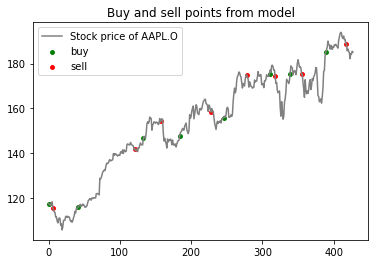

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,0.298659,0.166337,0.135087,1.231332,-0.105202,1.581122


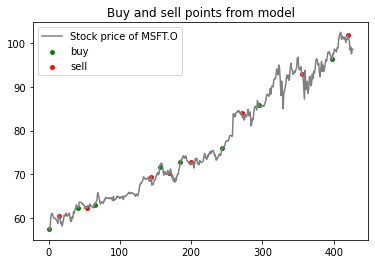

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,0.36168,0.199338,0.204417,0.975151,-0.148999,1.337848


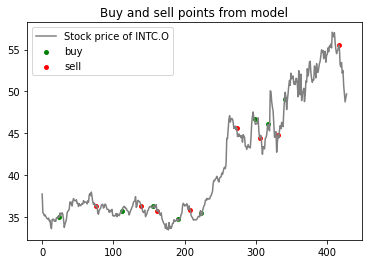

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,0.052268,0.030452,0.168149,0.1811,-0.249651,0.121977


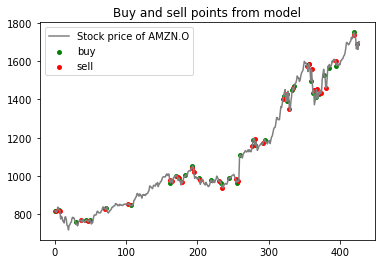

,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,0.266904,0.14946,0.141032,1.05976,-0.122272,1.222364


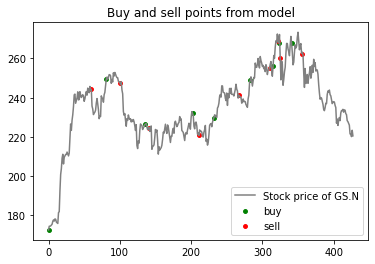

In [19]:
print("\n--- For the enhanced model ---")

for i in range(len(stock_list)):
    findEnhancedProfit(stock_list[i], amzn, stock_name_list[i], graph = True)

In [20]:
print("--- Basic model ---")
basic_perf_all = {}
basic_accuracy_all = {}
basic_precision_all = {}
for i in range(len(stock_list)):
    profit, basic_accuracy, basic_precision = findProfit(stock_list[i], stock_name_list[i])
    
    basic_perf_all[stock_name_list[i]] = profit
    basic_accuracy_all[stock_name_list[i]] = basic_accuracy
    basic_precision_all[stock_name_list[i]] = basic_precision
        
enhanced_perf_all = {}
enhanced_accuracy_all = {}
enhanced_precision_all = {}
print("\n\n--- Enhanced model ---")
for i in range(len(stock_list)):
    
    enhanced_profit, enhanced_accuracy, enhanced_precision = findEnhancedProfit(stock_list[i], amzn, stock_name_list[i])

    enhanced_perf_all[stock_name_list[i]] = enhanced_profit
    enhanced_accuracy_all[stock_name_list[i]] = enhanced_accuracy
    enhanced_precision_all[stock_name_list[i]] = enhanced_precision

--- Basic model ---


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,1.804559,0.835253,0.14154,5.901196,-0.06088,13.719754


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,2.523972,1.099348,0.13988,7.859202,-0.023345,47.09203


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,2.298004,1.01901,0.178808,5.698909,-0.067433,15.11154


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,4.822722,1.821596,0.181761,10.021932,-0.077695,23.445381


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,2.536753,1.103828,0.14233,7.755404,-0.037387,29.524367




--- Enhanced model ---


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AAPL.O,0.409985,0.224208,0.126068,1.778472,-0.067235,3.334714


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
MSFT.O,0.298659,0.166337,0.135087,1.231332,-0.105202,1.581122


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
INTC.O,0.36168,0.199338,0.204417,0.975151,-0.148999,1.337848


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
AMZN.O,0.052268,0.030452,0.168149,0.1811,-0.249651,0.121977


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
GS.N,0.266904,0.14946,0.141032,1.05976,-0.122272,1.222364


# Strategy 2

## Mean Reversion Strategy with Logistic Regression

Mean reversion is a financial theory suggesting that asset prices and returns tend to move back towards their long-term average or mean over time. The mean reversion trading strategy is based on the idea that when the price of an asset deviates significantly from its historical average, it is likely to revert back to the mean.

In this project (For basic model):

- SMA and Simple moving std as indicators for stock prices (Decide stock positions depend on the deviations of the stock prices on long-term means / Z-scores)

- RSI to have tighter bounds on considering stock positions

Steps on trading strategy integration and evaluation:

1. Process data set and extract required stock data.

2. Data cleaning.

3. Feature engineering.

4. Apply strategy.

5. Train model.

6. Apply model.

7. Evaluate model.

8. Enhance startegy / model. (MACD, Bollinger Bands, optimal grid search)

### Import statement

In [21]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from itertools import product
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
pd.options.mode.chained_assignment = None
%matplotlib inline

### Data preprocessing

In [22]:
import math
# Load the csv data file and extract the required (5) stocks.
data_file_name = 'tr_eikon_eod_data.csv'
data = pd.read_csv(data_file_name, index_col=0, parse_dates=True)
data = data[['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']].dropna()

def split_train_test(data, test=0.2):
    """
    Split the input data into train set and test set sequentially according to the test percentage stated.
    
    Parameters:
        data (pd.DataFrame): DataFrame that consists stock prices data.
        test (float): Percentage required for a test set with respective to the data set.
        
    Returns:
        (train_data, test_data) (pd.DataFrame, pd.DataFrame): Separate DataFrames of stock prices for training and testing 
                                                        respectively.
    """
    train_data = data[:math.floor(-test * len(data))]
    test_data = data[math.floor(-test * len(data)):]
    
    return train_data, test_data

def extract_stock(symbol, train_data, test_data):
    """
        Extract the stock data for a given symbol and uniform the stock name column as 'price'.

        Parameters:
            symbol (str): The stock symbol to extract.
            train_data (pd.DataFrame): DataFrame of stock prices for training.
            test_data (pd.DataFrame): DataFrame of stock prices for testing.

        Returns:
            (train_stock, test_stock) (pd.DataFrame, pd.DataFrame): Separate DataFrames of the {symbol} stock prices for 
                                                              training and testing respectively.
    """
    train_stock = train_data[symbol].to_frame().rename(columns={symbol: 'price'})
    test_stock = test_data[symbol].to_frame().rename(columns={symbol: 'price'})
    
    return train_stock, test_stock

# Split loaded data into train data and test data.
train_data, test_data = split_train_test(data)

# Extract unique train and test data for each stock respectively.
train_aapl, test_aapl = extract_stock('AAPL.O', train_data, test_data)
train_msft, test_msft = extract_stock('MSFT.O', train_data, test_data)
train_intc, test_intc = extract_stock('INTC.O', train_data, test_data)
train_amzn, test_amzn = extract_stock('AMZN.O', train_data, test_data)
train_gsn, test_gsn = extract_stock('GS.N', train_data, test_data)

### Basic Model Class

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
pd.options.mode.chained_assignment = None
%matplotlib inline

class MeanReversion:
    """
    A class to perform mean reversion strategy with logistic regression on stock data.

    Attributes:
        symbol (str): The stock symbol.
        features (list): List of features used in the model.
        max_iter (int): Maximum number of iterations for the logistic regression model.
        default_capital (float): Default capital for trading.
        default_shares (int): Default number of shares for trading.
        window (int): Size of the rolling window for calculating rolling mean and standard deviation.
        risk_free_rate (float): Risk-free rate for calculating Sharpe Ratio.
        train (pd.DataFrame): DataFrame of training data.
        test (pd.DataFrame): DataFrame of testing data.
        train_rev (pd.DataFrame): DataFrame of training data after adding features and running mean reversion.
        test_rev (pd.DataFrame): DataFrame of testing data after adding features and running mean reversion.
        test_ml (pd.DataFrame): DataFrame of testing data after adding features for machine learning prediction.
        y_train_rev (pd.Series): Series of target values of positions in training data.
        y_test_rev (pd.Series): Series of target values of positions in testing data for mean reversion.
        y_test_ml (pd.Series): Series of target values of positions in testing data for machine learning prediction.
        profit_loss (float): Difference in profit between machine learning and mean reversion strategies on testing data.
        accuracy (float): Accuracy of the machine learning model with respective to the mean reversion strategies on testing
                          data.
        metrics (dict): Dictionary to store evaluation metrics.
        result (dict): Dictionary to store the results of the mean reversions and machine learning model.
        metrics_df (pd.DataFrame): DataFrame to store evaluation metrics in tabulated format.
        overall_df (pd.DataFrame): DataFrame to store overall scores of the strategy.
        correlations (pd.DataFrame): DataFrame to store correlations between features and prices.
        
        Methods:
        __init__()
            Initializes the MeanReversion object.
        add_features(stock)
            Adds features to the stock DataFrame.
        run_mean_reversion(stock)
            Runs the Mean Reversion strategy on the stock data.
        evaluate_profit(stock)
            Evaluates the profit of the strategy.
        overall_score(df_k, df)
            Calculates the overall score of the strategy.
        tabulate_res()
            Tabulates the results of the strategy.
        fit(symbol, train, window=20, capital=10000, shares=0, risk_free_rate=0)
            Fits the Mean Reversion model to the training data and fit the training data and result to train the Logistic 
            Regression model.
        predict(test)
            Makes predictions using the Logistic Regression model of Mean Reversion on the test data.
        evaluate()
            Evaluates the performance of the strategies.
        compare(compare_list)
            Compares the performance of different stocks using the Mean Reversion (with or without Logistic Regression) strategy.
        get_label(attr)
            Gets the value of a label attribute.
        set_label(attr, value)
            Sets the value of a label attribute.
    """
    
    def __init__(self):
        """
        Initializes a MeanReversion object.
        """
        # Initialize variables
        self.symbol = ""
        self.features = ['price_lag1', 'price_lag2', 'price_lag3', 'price_lag4', 'price_lag5', 'roll_mean', 'roll_std', 'rsi']
        self.max_iter = 5000
        self.default_capital = 10000
        self.default_shares = 0
        self.window = 20
        self.risk_free_rate = 0
        self.train = None
        self.test = None
        self.train_rev = None
        self.test_rev = None
        self.test_ml = None
        self.y_train_rev = None
        self.y_test_rev = None
        self.y_test_ml = None
        self.profit_loss = None
        self.accuracy = None
        self.metrics = {}
        self.result = {}
        self.metrics_df = {}
        self.overall_df = {}
        self.correlations = {}
        
    def add_features(self, stock):
        """
        Add additional features to the stock data for subsequent stock position decisions.

        Parameters:
            stock (pd.DataFrame): DataFrame of stock prices.

        Returns:
            df (pd.DataFrame): DataFrame with added features.
        """
        df = stock.copy(deep=True)
        
        for i in range(1, 6):
            # Add lagged price features
            colname = 'price_lag' + str(i)
            df[colname] = df['price'].shift(i)
            
        # Calculate rolling mean and standard deviation
        df['roll_mean'] = df['price'].rolling(self.window).mean()
        df['roll_std'] = df['price'].rolling(self.window).std()
        
        # Calculate RSI
        df['delta'] = df['price'].diff()
        df['gain'] = df['delta'].where(df['delta'] > 0, 0)
        df['loss'] = -df['delta'].where(df['delta'] < 0, 0)
        df['ema_gain'] = df['gain'].ewm(alpha=0.8, min_periods=self.window).mean()
        df['ema_loss'] = df['loss'].ewm(alpha=0.8, min_periods=self.window).mean()
        df['rs'] = df['ema_gain'] / df['ema_loss']
        df['rsi'] = 100 - 100 / (1 + df['rs'])
        
        return df
        
    def run_mean_reversion(self, stock):
        """
        Run the mean reversion strategy on the stock data.

        Parameters:
            stock (DataFrame): DataFrame of stock prices and features.

        Returns:
            (df, df['position']) (pd.DataFrame, Series): DataFrame with added position column and Series of positions.
        """
        df = stock.copy(deep=True)
        
        # Run mean reversion strategy
        long_signal = (df['price'] < df['roll_mean'] - df['roll_std']) & (df['rsi'] < 30)
        short_signal = (df['price'] > df['roll_mean'] + df['roll_std']) & (df['rsi'] > 70)
        
        # 1 : long ; -1 : short ; 0 : otherwise
        df['position'] = long_signal.astype(int) - short_signal.astype(int)
        # End-of-day data is used, position is predicted for the next day, prevent lookahead bias
        df['position'] = df['position'].shift(1)
        df['position'] = df['position'].fillna(0)
        
        return df, df['position']
    
    def evaluate_profit(self, stock):
        """
        Evaluate the profit/loss of the strategy.

        Parameters:
            stock (pd.DataFrame): DataFrame of stock prices and features.

        Returns:
            df (pd.DataFrame): DataFrame with added columns for profit/loss calculation and accumulated wealth.
        """
        capital = self.default_capital
        shares = self.default_shares
        
        df = stock.copy(deep=True)
        
        base_wealth = capital + shares * df['price'].iloc[0]
        
        df['current'] = 0
        df['capital'] = 0
        df['shares'] = 0
        
        for i in range(len(df)):
            curr_price = df['price'].iloc[i]
            
            # 'Buy all' : Buy as many shares as possible
            if df['position'].iloc[i] == 1 and capital >= curr_price:
                share = capital // curr_price
                shares += share
                capital -= share * curr_price
                
            # 'Sell all' : Sell all shares held
            elif df['position'].iloc[i] == -1 and shares > 0:
                capital += shares * curr_price
                shares = 0
            
            # Calculate current wealth
            df['current'].iloc[i] = shares * curr_price + capital
            df['capital'].iloc[i] = capital
            df['shares'].iloc[i] = shares
            
        # Percentage growth of current wealth with respect to the base wealth 
        df['profit_accum'] = (df['current'] - base_wealth) / base_wealth
        # Percentage growth of current wealth with respect to the previous wealth
        df['profit_lag1'] = df['current'].diff() / df['current'].shift(1)
        # Correlations of features with respect to the stock prices
        self.correlations = pd.DataFrame(df.corr()['price'])
        
        return df
    
    def overall_score(self, df_k, df):
        """
        Calculate overall scores such as Base Profit, Annualized Return, Annualized Volatility,
        Sharpe Ratio, Max Drawdown, and Calmar Ratio.

        Parameters:
            df_k (str): Key for identifying the DataFrame.
            df (pd.DataFrame): DataFrame containing generated profit and loss data.
        """
        temp = {}
        
        temp['Base Profit'] = df['profit_accum'][-1]
        temp['Annualized Return'] = np.prod(1 + df['profit_lag1'])**(252 / len(df)) - 1
        temp['Annualized Volatility'] = np.std(df['profit_lag1']) * np.sqrt(252)
        temp['Sharpe Ratio'] = (temp['Annualized Return'] - self.risk_free_rate) / temp['Annualized Volatility']
        
        cum_returns = np.cumprod(1 + df['profit_lag1'][~df['profit_lag1'].isnull()])
        peak = np.maximum.accumulate(cum_returns)
        drawdowns = (cum_returns - peak) / peak
        temp['Max Drawdown'] = np.min(drawdowns)
        
        temp['Calmar Ratio'] = temp['Annualized Return'] / abs(temp['Max Drawdown'])
        
        # Store calculated metrics in the overall metrics dictionary
        self.metrics[df_k] = temp
    
    def tabulate_res(self):
        """
        Tabulate the results of the evaluation metrics.
        """
        self.profit_loss = self.metrics['test_ml']['Base Profit'] - self.metrics['test_rev']['Base Profit']
        
        # Store the profit difference between the ML and MR strategies for test set in the metrics dictionary
        self.metrics['test_ml']['Profit diff in ML (vs MR)'] = self.profit_loss
        self.metrics['train']['Profit diff in ML (vs MR)'] = np.nan
        self.metrics['test_rev']['Profit diff in ML (vs MR)'] = np.nan
        
        # Create a multi-index for the DataFrame, with "Stock" as first index, "Model" as second index
        index = pd.MultiIndex.from_tuples([(self.symbol, model_type) for model_type in self.metrics.keys()], \
                                          names=["Stock", "Model"])
        self.metrics_df = pd.DataFrame(self.metrics.values(), index=index)
        
        # Generate a classification report for the test_rev and test_ml predictions
        self.report = classification_report(self.y_test_rev, self.y_test_ml, labels=[-1, 0, 1], \
                                                           target_names=['short', 'keep', 'long'], output_dict=True, zero_division=1)

        self.report['accuracy'] = {'precision': np.nan, 'recall': np.nan, \
                                   'f1-score': self.report['accuracy'], 'support': self.report['macro avg']['support']}
        
        # Create a multi-index for the overall DataFrame, with "Stock" as first index, "Measure" as second index
        index_r = pd.MultiIndex.from_tuples([(self.symbol, report_idx) for report_idx in self.report.keys()], \
                                          names=["Stock", "Measure"])

        # Create a DataFrame from the classification report
        self.overall_df = pd.DataFrame(self.report.values(), index=index_r)
        
    def fit(self, symbol, train, window=20, capital=10000, shares=0, risk_free_rate=0):
        """
        Fit the Mean Reversion startegy on the training data, train the Logistic Regression model with
        the training data and the training result from the Mean Reversion strategy.

        Parameters:
            symbol (str): The symbol of the stock.
            train (pd.DataFrame): The training data containing the stock prices.
            window (int): The window size for calculating rolling mean and standard deviation.
            capital (float): The initial capital for trading.
            shares (int): The initial number of shares held.
            risk_free_rate (float): The risk-free rate for calculating Sharpe Ratio.

        Returns:
            self: Returns an instance of the class with the model fitted.
        """
        self.window = window
        self.default_capital = capital
        self.default_shares = shares
        self.risk_free_rate = risk_free_rate
        self.symbol = symbol
        self.train = train
        
        # Add features to the training data and drop any rows with NaN values
        self.train_rev = self.add_features(self.train).dropna()
        
        # Run the mean reversion strategy on the training data
        self.train_rev, self.y_train_rev = self.run_mean_reversion(self.train_rev)
        
        # Evaluate the profit/loss of the strategy on the training data
        self.train_rev = self.evaluate_profit(self.train_rev)
        
        # Store the training data and results in the result dictionary
        self.result['train'] = self.train_rev
        
        # Create and fit a logistic regression model to the training data
        self.model = LogisticRegression(max_iter=self.max_iter)
        self.model.fit(self.train_rev[self.features], self.y_train_rev)
        
        # Return the instance of the class with the model fitted
        return self
    
    def predict(self, test):
        """
        Make predictions using the Logistic Regression model of Mean Reversion on the test data.

        Parameters:
            test (pd.DataFrame): The test data containing the stock prices.

        Returns:
            y_test_ml (array): The predicted positions (1 for long, -1 for short, 0 for keep) for the test data.
        """
        self.test = test
        
        # Add features to the test data and drop any rows with NaN values
        self.test_rev = self.add_features(self.test).dropna()
        
        # Run the mean reversion strategy on the test data
        self.test_rev, self.y_test_rev = self.run_mean_reversion(self.test_rev)
        
        # Evaluate the profit/loss of the strategy on the test data
        self.test_rev = self.evaluate_profit(self.test_rev)
        
        # Store the test data and the results on raw mean reversion of test data in the result dictionary
        self.result['test_rev'] = self.test_rev
        
        # Add features to the test data for machine learning and drop any rows with NaN values
        self.test_ml = self.add_features(self.test).dropna()
        
        # Make predictions using the logistic regression model on the test data
        test_pred = self.model.predict(self.test_ml[self.features])

        # Store the predicted positions in the test data
        self.test_ml['position'] = test_pred
        
        # Store the predicted positions as y_test_ml
        self.y_test_ml = test_pred
        
        # Evaluate the profit/loss of the machine learning model on the test data
        self.test_ml = self.evaluate_profit(self.test_ml)
        
        # Store the test data with machine learning results in the result dictionary
        self.result['test_ml'] = self.test_ml
        
        # Return the predicted positions for the test data
        return self.y_test_ml
    
    def evaluate(self):
        """
        Evaluate the Mean Reversion strategy whether with the presence of Logistic Regression model on the data 
        and display relevant plots and metrics.
        """
        # Plot the training stock prices and the trading positions from raw mean reversion
        fig, ax = plt.subplots(1, 2, figsize=(18, 6))
        ax[0].plot(self.train_rev['price'])
        ax[0].plot(self.train_rev[self.train_rev['position'] == 1]['price'], 'g.', label='long')
        ax[0].plot(self.train_rev[self.train_rev['position'] == -1]['price'], 'r.', label='short')
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Price')
        ax[0].legend()
        ax[0].set_title('Train Price of ' + self.symbol + ' against Time with Trading Position')

        # Plot the wealth curve from training set and the trading positions from raw mean reversion
        ax[1].plot(self.train_rev['current'])
        ax[1].plot(self.train_rev[self.train_rev['position'] == 1]['current'], 'g.', label='long')
        ax[1].plot(self.train_rev[self.train_rev['position'] == -1]['current'], 'r.', label='short')
        ax[1].set_xlabel('Time')
        ax[1].set_ylabel('Wealth')
        ax[1].legend()
        ax[1].set_title('Current Wealth from Raw Mean Reversion Applied on Train Price of ' + self.symbol + ' against Time')

        # Plot the training stock prices and the trading positions from mean reversion with logistic regression
        fig, ax1 = plt.subplots(1, 2, figsize=(18, 6))
        ax1[0].plot(self.test['price'])
        ax1[0].plot(self.test_ml[self.test_ml['position'] == 1]['price'], 'g.', label='long')
        ax1[0].plot(self.test_ml[self.test_ml['position'] == -1]['price'], 'r.', label='short')
        ax1[0].set_xlabel('Time')
        ax1[0].set_ylabel('Price')
        ax1[0].legend()
        ax1[0].set_title('Test Price of ' + self.symbol + ' against Time with Trading Position from ML model')

        # Plot the wealth curve resulted from the raw mean reversion test set and the logistic regression test set
        ax1[1].plot(self.test_rev['current'], 'b', label='rev')
        ax1[1].plot(self.test_ml['current'], 'r', label='ml')
        ax1[1].set_xlabel('Time')
        ax1[1].set_ylabel('Wealth')
        plt.legend()
        ax1[1].set_title('Current Wealth on Test Price of ' + self.symbol + ' against Time')
        
        plt.show()
        
        # Reset the metrics dictionary
        self.metrics = {}
        
        # Calculate and tabulate evaluation metrics
        for df_k, df_v in self.result.items():
            self.overall_score(df_k, df_v)
        
        self.tabulate_res()
        
        # Display evaluation metrics and overall model score
        print('\nEvaluation metrics on different datasets of', self.symbol)
        
        display(self.metrics_df)
        
        print('\nOverall score of strategy on', self.symbol)
        
        display(self.overall_df)
        
        #print('\nCorrelations between features and prices for', self.symbol) # find optimal combination of learning features
        
        #display(self.correlations)
    
    @staticmethod
    def compare(compare_list):
        """
        Compare the performance of multiple Mean Reversion strategies (with or without Logistic Regression) on different stocks.

        Parameters:
            compare_list (list): A list of Mean Reversion instances to compare.

        Returns:
            d_mets (pd.DataFrame): Evaluation metrics on different datasets of different stocks.
            d_overalls (pd.DataFrame): Overall score of machine learning model on different stocks.
            d_mets_avg (pd.DataFrame): Average performance on trading evaluation metrics.
            d_overalls_avg (pd.DataFrame): Overall machine learning model score.
        """
        # Initialize empty lists to store metrics and overall ml model scores for each stock
        mets = []
        overalls = []
        
        # Iterate over the list of stocks to collect metrics and overall ml model scores
        for stock in compare_list:
            mets.append(stock.metrics_df)
            overalls.append(stock.overall_df)
        
        # Concatenate the metrics and overall ml model scores, and sort them for display
        d_mets = pd.concat(mets).swaplevel('Stock', 'Model').reset_index()
        d_mets = d_mets.sort_values('Base Profit', ascending=False).sort_values('Model').set_index(['Model', 'Stock'])
        
        d_overalls = pd.concat(overalls).swaplevel('Stock', 'Measure').reset_index()
        d_overalls = d_overalls.sort_values('Measure').set_index(['Measure', 'Stock'])
        
        # Display the metrics and overall ml model scores
        print('\nEvaluation metrics on different datasets of different stocks')
        display(d_mets)
        
        print('\nOverall score of strategy on different stocks')
        display(d_overalls)
        
        # Calculate and display the average performance metrics and overall machine learning model score
        print('\nAverage performance on')
        print('\nEvaluation metrics')
        d_mets_avg = d_mets.groupby('Model').mean().sort_values('Base Profit', ascending=False)
        display(d_mets_avg)
        
        print('\nOverall machine learning model score')
        d_overalls_avg = d_overalls.groupby('Measure').mean()
        display(d_overalls_avg)
        
        # Return the concatenated metrics, overall ml model scores, average metrics, and average overall ml model scores
        return d_mets, d_overalls, d_mets_avg, d_overalls_avg
    
    def get_label(self, attr):
        """
        Get the value of an attribute of the Mean Reversion instance.

        Parameters:
            attr (str): The name of the attribute to get.

        Returns:
            value: The value of the attribute.
        """
        # Return the value of the attribute 'attr' from the object 'self', or None if the attribute does not exist
        return getattr(self, attr, None)
    
    def set_label(self, attr, value):
        """
        Set the value of an attribute of the Mean Reversion instance.

        Parameters:
            attr (str): The name of the attribute to set.
            value: The value to set.
        """
        # Set the attribute 'attr' of the object 'self' to the specified 'value', create new attribute if not exist
        setattr(self, attr, value)

#### Evaluation metrics

##### Trading Strategy Metrics

1. Base Profit

    - The total profit generated by a trading strategy with respect to the initial capital.
    

2. Annualized Return

    - The average rate of return per year, calculated as the geometric mean of the cumulative returns.


3. Annualized Volatility	

    - The standard deviation of the daily returns of a trading strategy, annualized by multiplying by the square root of the number of trading days in a year (typically 252).


4. Sharpe Ratio	

    - A measure of risk-adjusted return, calculated as the ratio of the excess return (return above the risk-free rate) to the volatility of the strategy's returns.


5. Max Drawdown	

    - The maximum loss from a peak to a trough of a portfolio, before a new peak is attained.


6. Calmar Ratio	

    - The ratio of the annualized return of a trading strategy to its maximum drawdown, used to assess risk-adjusted performance.


7. Profit diff in ML (vs MR)

    - The difference in profit between a machine learning (ML) based trading strategy and a mean reversion (MR) trading strategy on the test dataset.


##### Machine Learning Model Scores

**Classification Classes: 1 : Long ; -1 : Short ; 0 : Keep**

1. Accuracy

    - The proportion of correct predictions (both true positives and true negatives) among the total number of predictions.
    
    
2. Macro Avg

    - The average of the scores of each class, without considering class imbalance.


3. Weighted Avg

    - The weighted average of the scores of each class, where each score is weighted by the number of true instances in each class.

i. Precision	

    - The proportion of true positive predictions among all positive predictions (true positive + false positive).

ii. Recall

    - The proportion of true positive predictions among all actual positive instances (true positive + false negative).

iii. f1-score

    - The harmonic mean of precision and recall, providing a balance between the two metrics.

iv. Support

    - The number of occurrences of each class in the true instances.

### Basic model evaluation

#### AAPL.O

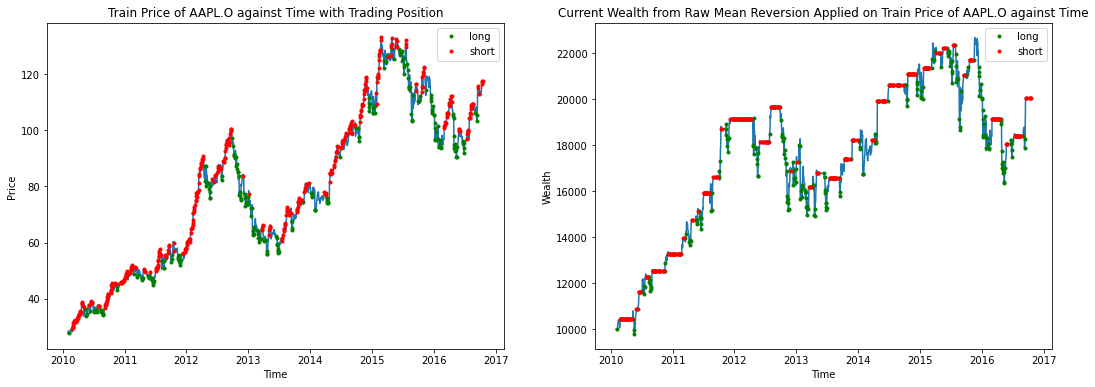

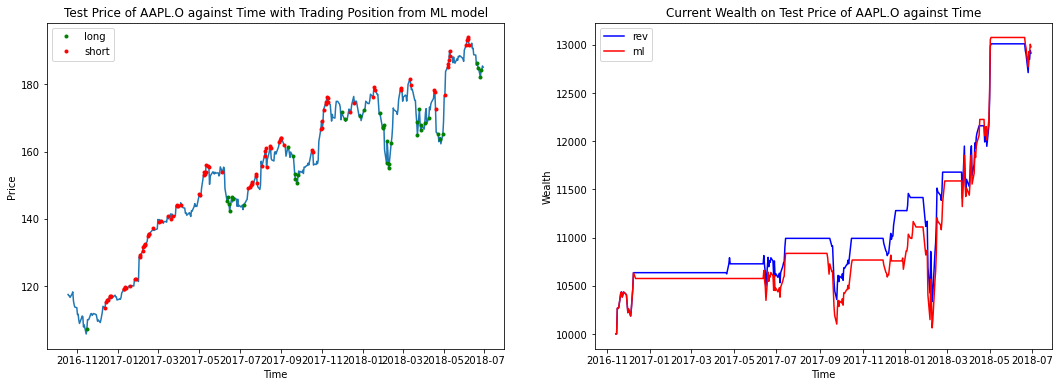


Evaluation metrics on different datasets of AAPL.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
AAPL.O train        1.003056           0.109072               0.192388   
       test_rev     0.291471           0.170694               0.125432   
       test_ml      0.297928           0.174297               0.127560   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
AAPL.O train         0.566936     -0.277835      0.392577   
       test_rev      1.360843     -0.097922      1.743154   
       test_ml       1.366391     -0.098841      1.763413   

                 Profit diff in ML (vs MR)  
Stock  Model                                
AAPL.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.006457


Overall score of strategy on AAPL.O


precision    recall  f1-score  support
Stock  Measure                                             
AAPL.O short          0.928571  0.791304  0.854460      115
       keep           0.885185  0.948413  0.915709      252
       long           0.853659  0.833333  0.843373       42
       accuracy            NaN       NaN  0.892421      409
       macro avg      0.889138  0.857683  0.871181      409
       weighted avg   0.894147  0.892421  0.891059      409

In [24]:
aapl_basic_model = MeanReversion().fit('AAPL.O', train_aapl)
aapl_basic_pred = aapl_basic_model.predict(test_aapl)
aapl_basic_model.evaluate()

##### Observation
The mean reversion machine learning model performs slightly better than raw mean reversion on the APPL.O test data.

#### MSFT.O

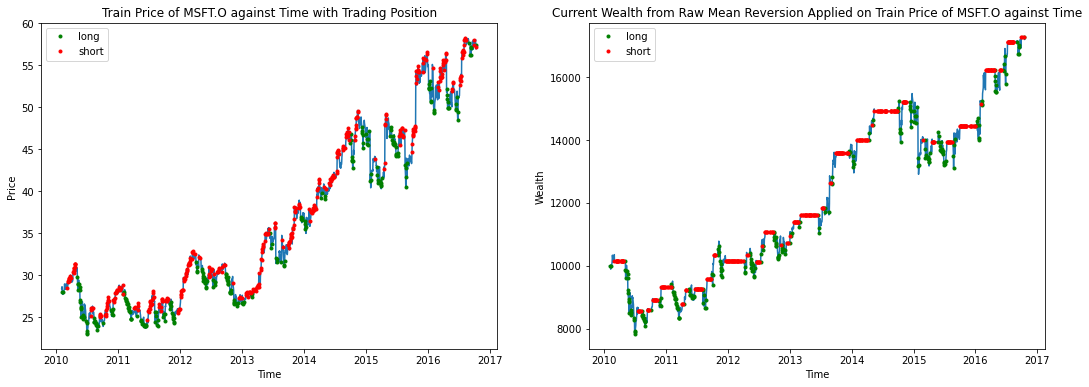

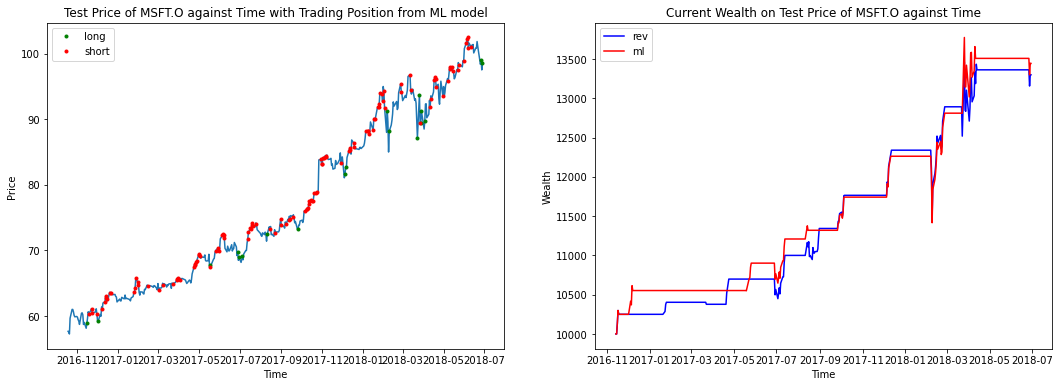


Evaluation metrics on different datasets of MSFT.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
MSFT.O train        0.720380           0.084211               0.161958   
       test_rev     0.329898           0.192035               0.121079   
       test_ml      0.344384           0.200019               0.117124   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
MSFT.O train         0.519953     -0.243816      0.345387   
       test_rev      1.586031     -0.069145      2.777293   
       test_ml       1.707754     -0.069064      2.896139   

                 Profit diff in ML (vs MR)  
Stock  Model                                
MSFT.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.014486


Overall score of strategy on MSFT.O


precision    recall  f1-score  support
Stock  Measure                                             
MSFT.O short          0.834711  0.848739  0.841667      119
       keep           0.910781  0.914179  0.912477      268
       long           0.842105  0.727273  0.780488       22
       accuracy            NaN       NaN  0.885086      409
       macro avg      0.862532  0.830064  0.844877      409
       weighted avg   0.884954  0.885086  0.884775      409

In [25]:
msft_basic_model = MeanReversion().fit('MSFT.O', train_msft)
msft_basic_pred = msft_basic_model.predict(test_msft)
msft_basic_model.evaluate()

##### Observation
The mean reversion machine learning model performs slightly better than raw mean reversion on the MSFT.O test data.

#### INTC.O

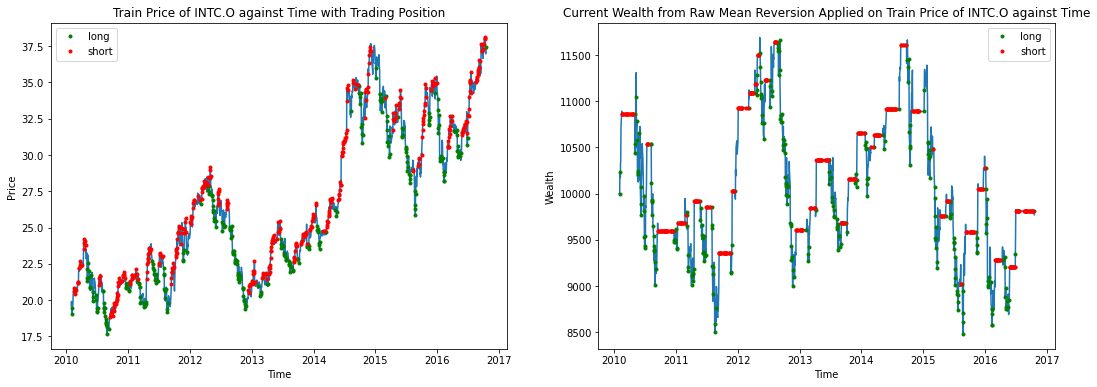

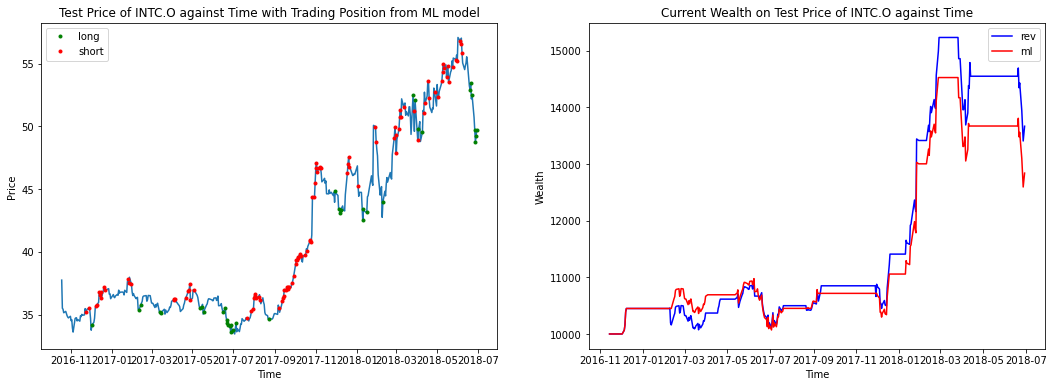


Evaluation metrics on different datasets of INTC.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
INTC.O train       -0.022872          -0.003442               0.170588   
       test_rev     0.366540           0.212166               0.158813   
       test_ml      0.283836           0.166425               0.151717   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
INTC.O train        -0.020178     -0.274639     -0.012533   
       test_rev      1.335947     -0.119914      1.769314   
       test_ml       1.096939     -0.132948      1.251802   

                 Profit diff in ML (vs MR)  
Stock  Model                                
INTC.O train                           NaN  
       test_rev                        NaN  
       test_ml                   -0.082704


Overall score of strategy on INTC.O


precision    recall  f1-score  support
Stock  Measure                                             
INTC.O short          0.900990  0.850467  0.875000      107
       keep           0.870370  0.951417  0.909091      247
       long           0.947368  0.654545  0.774194       55
       accuracy            NaN       NaN  0.885086      409
       macro avg      0.906243  0.818810  0.852761      409
       weighted avg   0.888735  0.885086  0.882032      409

In [26]:
intc_basic_model = MeanReversion().fit('INTC.O', train_intc)
intc_basic_pred = intc_basic_model.predict(test_intc)
intc_basic_model.evaluate()

##### Observation
The mean reversion machine learning model performs worse than raw mean reversion on the INTC.O test data.

It had a relatively sharp decreasing price trends in the train data set.

#### AMZN.O

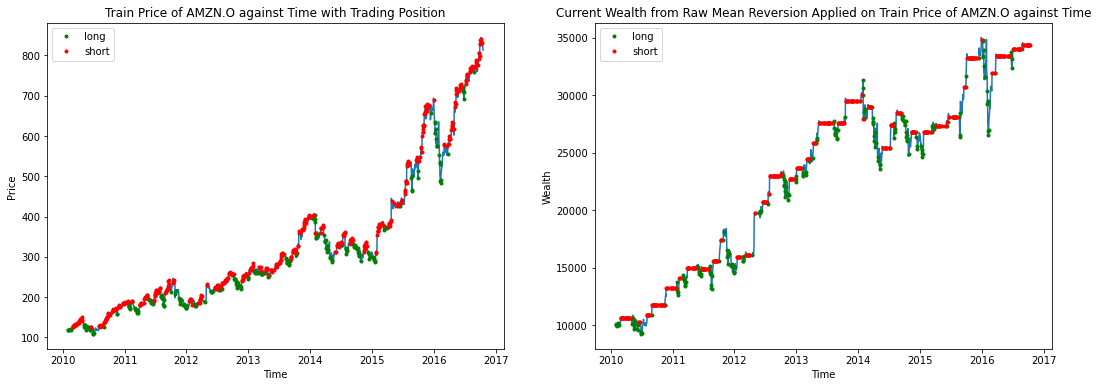

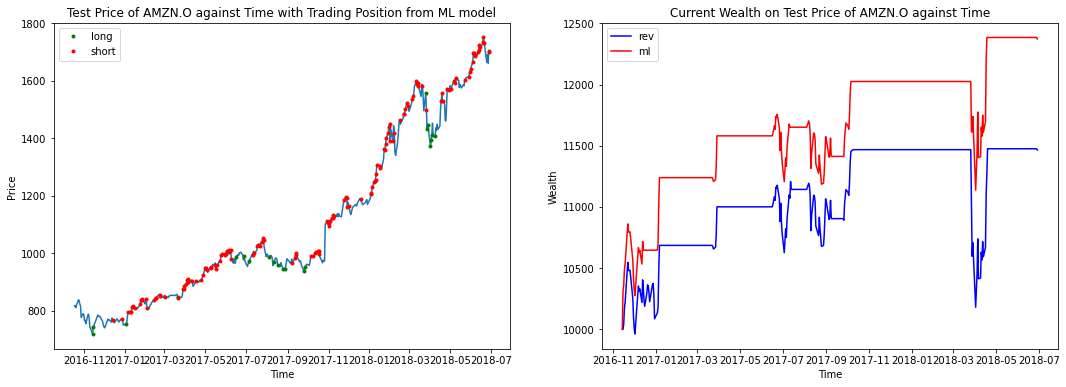


Evaluation metrics on different datasets of AMZN.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
AMZN.O train        2.441669           0.202241               0.223634   
       test_rev     0.146516           0.087893               0.116055   
       test_ml      0.237265           0.140170               0.109824   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
AMZN.O train         0.904342     -0.245745      0.822970   
       test_rev      0.757342     -0.112236      0.783111   
       test_ml       1.276313     -0.073775      1.899966   

                 Profit diff in ML (vs MR)  
Stock  Model                                
AMZN.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.090749


Overall score of strategy on AMZN.O


precision    recall  f1-score  support
Stock  Measure                                             
AMZN.O short          0.863014  0.893617  0.878049      141
       keep           0.887967  0.902954  0.895397      237
       long           0.863636  0.612903  0.716981       31
       accuracy            NaN       NaN  0.877751      409
       macro avg      0.871539  0.803158  0.830142      409
       weighted avg   0.877520  0.877751  0.875894      409

In [27]:
amzn_basic_model = MeanReversion().fit('AMZN.O', train_amzn)
amzn_basic_pred = amzn_basic_model.predict(test_amzn)
amzn_basic_model.evaluate()

##### Observation
The mean reversion machine learning model performs more better than raw mean reversion on the AMZN.O test data.

#### GS.N

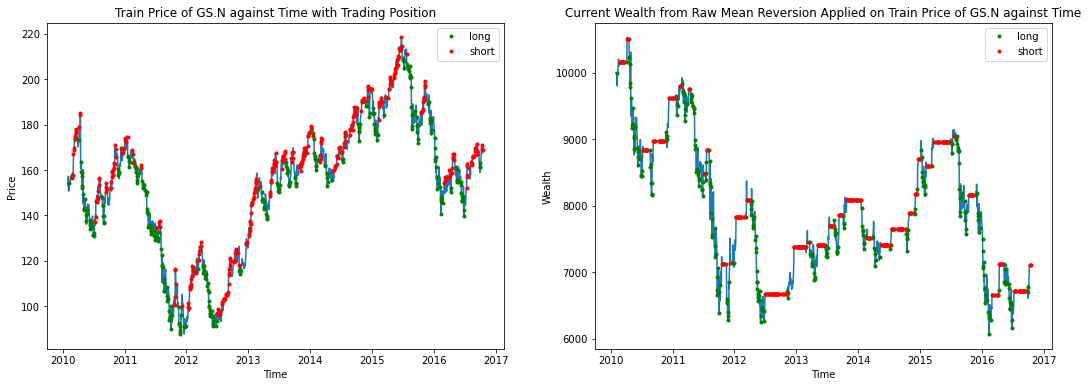

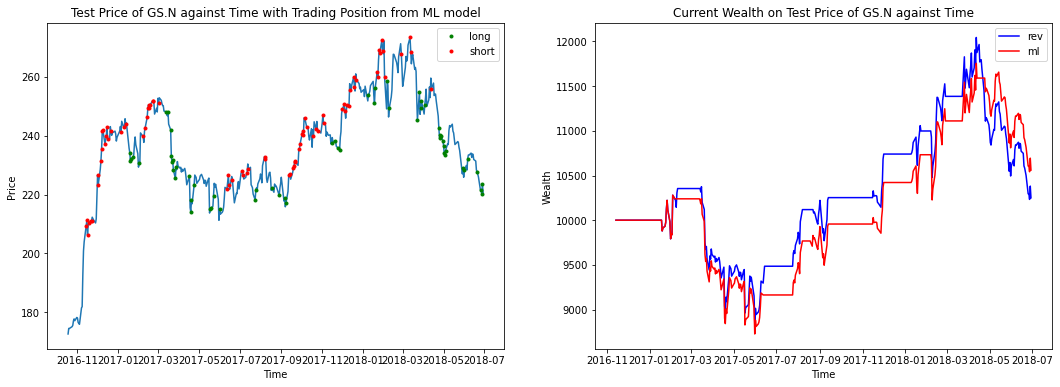


Evaluation metrics on different datasets of GS.N


Base Profit  Annualized Return  Annualized Volatility  \
Stock Model                                                             
GS.N  train       -0.289561          -0.049671               0.203789   
      test_rev     0.025021           0.015343               0.154227   
      test_ml      0.056031           0.034161               0.151562   

                Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock Model                                                
GS.N  train        -0.243738     -0.423577     -0.117266   
      test_rev      0.099485     -0.150506      0.101944   
      test_ml       0.225391     -0.151136      0.226026   

                Profit diff in ML (vs MR)  
Stock Model                                
GS.N  train                           NaN  
      test_rev                        NaN  
      test_ml                     0.03101


Overall score of strategy on GS.N


precision    recall  f1-score  support
Stock Measure                                             
GS.N  short          0.871795  0.918919  0.894737       74
      keep           0.926740  0.930147  0.928440      272
      long           0.844828  0.777778  0.809917       63
      accuracy            NaN       NaN  0.904645      409
      macro avg      0.881121  0.875615  0.877698      409
      weighted avg   0.904181  0.904645  0.904086      409

In [28]:
gsn_basic_model = MeanReversion().fit('GS.N', train_gsn)
gsn_basic_pred = gsn_basic_model.predict(test_gsn)
gsn_basic_model.evaluate()

##### Observation
The mean reversion machine learning model performs better than raw mean reversion on the GS.N test data.

#### Cross comparison between different stocks

In [29]:
stock_basic_models = [aapl_basic_model, msft_basic_model, intc_basic_model, amzn_basic_model, gsn_basic_model]
b_mets, b_overalls, b_mets_avg, b_overalls_avg = MeanReversion.compare(stock_basic_models)


Evaluation metrics on different datasets of different stocks


Base Profit  Annualized Return  Annualized Volatility  \
Model    Stock                                                           
test_ml  MSFT.O     0.344384           0.200019               0.117124   
         AAPL.O     0.297928           0.174297               0.127560   
         INTC.O     0.283836           0.166425               0.151717   
         AMZN.O     0.237265           0.140170               0.109824   
         GS.N       0.056031           0.034161               0.151562   
test_rev INTC.O     0.366540           0.212166               0.158813   
         MSFT.O     0.329898           0.192035               0.121079   
         AAPL.O     0.291471           0.170694               0.125432   
         AMZN.O     0.146516           0.087893               0.116055   
         GS.N       0.025021           0.015343               0.154227   
train    AMZN.O     2.441669           0.202241               0.223634   
         AAPL.O     1.003056           0.109072               0.192388   
         MSFT.O     0.720380           0.084211               0.161958   
         INTC.O    -0.022872          -0.003442               0.170588   
         GS.N      -0.289561          -0.049671               0.203789   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Model    Stock                                              
test_ml  MSFT.O      1.707754     -0.069064      2.896139   
         AAPL.O      1.366391     -0.098841      1.763413   
         INTC.O      1.096939     -0.132948      1.251802   
         AMZN.O      1.276313     -0.073775      1.899966   
         GS.N        0.225391     -0.151136      0.226026   
test_rev INTC.O      1.335947     -0.119914      1.769314   
         MSFT.O      1.586031     -0.069145      2.777293   
         AAPL.O      1.360843     -0.097922      1.743154   
         AMZN.O      0.757342     -0.112236      0.783111   
         GS.N        0.099485     -0.150506      0.101944   
train    AMZN.O      0.904342     -0.245745      0.822970   
         AAPL.O      0.566936     -0.277835      0.392577   
         MSFT.O      0.519953     -0.243816      0.345387   
         INTC.O     -0.020178     -0.274639     -0.012533   
         GS.N       -0.243738     -0.423577     -0.117266   

                 Profit diff in ML (vs MR)  
Model    Stock                              
test_ml  MSFT.O                   0.014486  
         AAPL.O                   0.006457  
         INTC.O                  -0.082704  
         AMZN.O                   0.090749  
         GS.N                     0.031010  
test_rev INTC.O                        NaN  
         MSFT.O                        NaN  
         AAPL.O                        NaN  
         AMZN.O                        NaN  
         GS.N                          NaN  
train    AMZN.O                        NaN  
         AAPL.O                        NaN  
         MSFT.O                        NaN  
         INTC.O                        NaN  
         GS.N                          NaN


Overall score of strategy on different stocks


precision    recall  f1-score  support
Measure      Stock                                         
accuracy     AMZN.O        NaN       NaN  0.877751      409
             AAPL.O        NaN       NaN  0.892421      409
             INTC.O        NaN       NaN  0.885086      409
             GS.N          NaN       NaN  0.904645      409
             MSFT.O        NaN       NaN  0.885086      409
keep         AAPL.O   0.885185  0.948413  0.915709      252
             INTC.O   0.870370  0.951417  0.909091      247
             MSFT.O   0.910781  0.914179  0.912477      268
             GS.N     0.926740  0.930147  0.928440      272
             AMZN.O   0.887967  0.902954  0.895397      237
long         INTC.O   0.947368  0.654545  0.774194       55
             AMZN.O   0.863636  0.612903  0.716981       31
             GS.N     0.844828  0.777778  0.809917       63
             AAPL.O   0.853659  0.833333  0.843373       42
             MSFT.O   0.842105  0.727273  0.780488       22
macro avg    GS.N     0.881121  0.875615  0.877698      409
             AAPL.O   0.889138  0.857683  0.871181      409
             INTC.O   0.906243  0.818810  0.852761      409
             AMZN.O   0.871539  0.803158  0.830142      409
             MSFT.O   0.862532  0.830064  0.844877      409
short        GS.N     0.871795  0.918919  0.894737       74
             AAPL.O   0.928571  0.791304  0.854460      115
             INTC.O   0.900990  0.850467  0.875000      107
             MSFT.O   0.834711  0.848739  0.841667      119
             AMZN.O   0.863014  0.893617  0.878049      141
weighted avg INTC.O   0.888735  0.885086  0.882032      409
             AMZN.O   0.877520  0.877751  0.875894      409
             MSFT.O   0.884954  0.885086  0.884775      409
             AAPL.O   0.894147  0.892421  0.891059      409
             GS.N     0.904181  0.904645  0.904086      409


Average performance on

Evaluation metrics


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Profit diff in ML (vs MR)
Model,,,,,,,
train,0.770534,0.068482,0.190471,0.345463,-0.293122,0.286227,NaN
test_ml,0.243889,0.143014,0.131558,1.134558,-0.105153,1.607469,0.012
test_rev,0.231889,0.135626,0.135121,1.027930,-0.109945,1.434963,NaN



Overall machine learning model score


,precision,recall,f1-score,support
Measure,,,,
accuracy,NaN,NaN,0.888998,409.0
keep,0.896209,0.929422,0.912223,255.2
long,0.870319,0.721167,0.784991,42.6
macro avg,0.882115,0.837066,0.855332,409.0
short,0.879816,0.860609,0.868782,111.2
weighted avg,0.889908,0.888998,0.887569,409.0


##### Overall Observation
The mean reversion machine learning model performs slightly better than raw mean reversion on the test data.

Most of the stocks have better performance when using the mean reversion machine learning model, except for INTC.O.

The average base profit is +24.39%, annualized return is +14.30%, annualized volatility is 13.16% and average accuracy of model 
is 88.90%.

### Enhancement 

#### Enhanced Model inherited from Basic Model

In [30]:
class EnhancedMeanReversion(MeanReversion):
    """
    A class for an enhanced mean reversion strategy with logistic regression using MACD signals and optimal 
    trading windows and factors.

    This class extends the MeanReversion class to include additional features and enhancements
    for a logistic regression - mean reversion trading strategy using MACD signals and optimal trading windows 
    and factors.

    Attributes:
        features (list): List of feature names used in the model.
        macd_short_window (int): Short window size for MACD calculation.
        macd_long_window (int): Long window size for MACD calculation.
        macd_signal_window (int): Signal window size for MACD calculation.
        long_f (float): Multiplier for long signal threshold.
        short_f (float): Multiplier for short signal threshold.

    Methods:
        add_macd_feature(stock): Adds MACD and MACD signal features to the stock data.
        run_mean_reversion(stock): Runs the mean reversion strategy with enhanced conditions.
        fit(symbol, train, window=10, capital=10000, shares=0, risk_free_rate=0, macd_short_window=10,
            macd_long_window=20, macd_signal_window=5, long_f=1.7, short_f=1.2): Fits the model using the
            enhanced features and conditions.
        predict(test): Predicts using the model with enhanced features and conditions.
        evaluate_enhancement(symbol, basic, enhance): Compares the performance of the enhanced strategy with
            the basic strategy.
        compare_enhancement(performance_growths): Compares the performance growths of different strategies.

    """
    def __init__(self):
        """Initializes the EnhancedMeanReversion class."""
        super().__init__()
        self.features = ['price_lag1', 'price_lag2', 'price_lag3', 'price_lag4', 'price_lag5', 'roll_mean', 'roll_std', 'rsi', \
                        'macd', 'macd_signal']
        self.macd_short_window = 10 
        self.macd_long_window = 20 
        self.macd_signal_window = 5 
        self.long_f = 1.7 
        self.short_f = 1.2 
        
    def add_macd_feature(self, stock):
        """
        Add MACD and MACD signal features to the stock data.

        Parameters:
            stock (pd.DataFrame): Stock data with basic features.

        Returns:
            df (pd.DataFrame): Stock data with added MACD and MACD signal features.
        """
        df = stock.copy(deep=True)
        
        # Calculate the short-term exponential moving average (EMA) of the price
        short_ema = df['price'].ewm(span=self.macd_short_window, adjust=False).mean()
        
        # Calculate the long-term exponential moving average (EMA) of the price
        long_ema = df['price'].ewm(span=self.macd_long_window, adjust=False).mean()
        
        # Calculate the Moving Average Convergence Divergence (MACD) line
        df['macd'] = short_ema - long_ema
        
        # Calculate the signal line using the MACD line
        df['macd_signal'] = df['macd'].ewm(span=self.macd_signal_window, adjust=False).mean()
        
        # Return the DataFrame with MACD and signal lines added
        return df
        
    def run_mean_reversion(self, stock):
        """
        Run the mean reversion strategy with enhanced conditions.

        Parameters:
            stock (pd.DataFrame): Stock data with features.

        Returns:
            df (pd.DataFrame): Stock data with added 'position' column indicating trading positions.
            df['position'] (pd.Series): Series of trading positions based on the mean reversion strategy.
        """
        df = stock.copy(deep=True)
        
        # Determine the long signals based on conditions: 
        # Z-score < -1, and RSI below 30
        long_signal = (df['price'] < df['roll_mean'] - self.long_f * df['roll_std']) & (df['rsi'] < 30) 
        
        # Determine the short signals based on conditions: 
        # Z-score > 1, RSI above 70, and MACD signal line greater than or equal to MACD line
        short_signal = (df['price'] > df['roll_mean'] + self.short_f * df['roll_std']) & (df['rsi'] > 70) & \
                        (df['macd_signal'] >= df['macd'])
        
        # Combine long and short signals to generate position: 1 for long, -1 for short, 0 for keep
        df['position'] = long_signal.astype(int) - short_signal.astype(int)
        
        # Shift the position by one time step to prevent lookahead bias
        df['position'] = df['position'].shift(1)
        
        # Fill NaN values with 0 (no position)
        df['position'] = df['position'].fillna(0)
        
        # Return the DataFrame with positions added, along with the positions as a Series
        return df, df['position']
    
    def fit(self, symbol, train, window=10, capital=10000, shares=0, risk_free_rate=0, \
            macd_short_window=10, macd_long_window=20, macd_signal_window=5, long_f = 1.7, short_f = 1.2):
        """
        Fit the mean reversion and logistic regression model using the enhanced features and conditions.

        Parameters:
            symbol (str): Symbol of the stock.
            train (pd.DataFrame): DataFrame of training data.
            window (int): Window size for rolling calculations (default=10).
            capital (float): Initial capital for trading (default=10000).
            shares (int): Number of shares held (default=0).
            risk_free_rate (float): Risk-free rate for calculations (default=0).
            macd_short_window (int): Short window size for MACD calculation (default=10).
            macd_long_window (int): Long window size for MACD calculation (default=20).
            macd_signal_window (int): Signal window size for MACD calculation (default=5).
            long_f (float): Multiplier for long signal threshold (default=1.7).
            short_f (float): Multiplier for short signal threshold (default=1.2).

        Returns:
            self: Returns an instance of the class with the model fitted.
        """
        self.window = window
        self.capital = capital
        self.shares = shares
        self.risk_free_rate = risk_free_rate
        self.macd_short_window = macd_short_window
        self.macd_long_window = macd_long_window
        self.macd_signal_window = macd_signal_window
        self.long_f = long_f
        self.short_f = short_f
        self.symbol = symbol
        self.train = train
        
        # Add the MACD feature to the training data with additional features
        self.train_rev = self.add_macd_feature(self.add_features(self.train)).dropna()
        
        self.train_rev, self.y_train_rev = self.run_mean_reversion(self.train_rev)
        
        self.train_rev = self.evaluate_profit(self.train_rev)
        
        self.result['train'] = self.train_rev
        
        self.model = LogisticRegression(max_iter=self.max_iter)
        
        self.model.fit(self.train_rev[self.features], self.y_train_rev)
        
        return self
    
    def predict(self, test):
        """
        Predict stock trading positions using the model with enhanced features and conditions.

        Parameters:
            test (pd.DataFrame): Dataframe of test data.

        Returns:
            self.y_test_ml (array): Array of predicted trading positions for the test set.
        """
        self.test = test
        
        # Add the MACD feature to the test data with additional features
        self.test_rev = self.add_macd_feature(self.add_features(self.test)).dropna()
        
        self.test_rev, self.y_test_rev = self.run_mean_reversion(self.test_rev)
        
        self.test_rev = self.evaluate_profit(self.test_rev)
        
        self.result['test_rev'] = self.test_rev
        
        # Add the MACD feature to the test data with additional features
        self.test_ml = self.add_macd_feature(self.add_features(self.test)).dropna()
        
        test_pred = self.model.predict(self.test_ml[self.features])

        self.test_ml['position'] = test_pred
        
        self.y_test_ml = test_pred
        
        self.test_ml = self.evaluate_profit(self.test_ml)
        
        self.result['test_ml'] = self.test_ml
        
        return self.y_test_ml
    
    @staticmethod
    def evaluate_enhancement(symbol, basic, enhance):
        """
        Compare the performance of the enhanced strategy with the basic strategy.

        Parameters:
            symbol (str): Symbol of the stock.
            basic (MeanReversion): Basic strategy instance.
            enhance (EnhancedMeanReversion): Enhanced strategy instance.

        Returns:
            diff_mets (pd.DataFrame): Difference in trading metrics between the enhanced and basic strategies.
            diff_scores (pd.DataFrame): Difference in machine learning model performance scores between the 
                                     enhanced and basic strategies.
        """
        print('Comparison of Wealth from')
        # Plot a graph on the wealth curves resulted from the basic and enhanced model for the training data using
        # raw mean reversion
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].plot(basic.train_rev['current'], 'b', label='basic')
        ax[0].plot(enhance.train_rev['current'], 'r', label='enhance')
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Wealth')
        ax[0].legend() 
        ax[0].set_title('Raw Strategy on Train Price of ' + symbol)

        # Plot a graph on the wealth curves resulted from the basic and enhanced model for the test data using
        # mean reversion with logistic regression 
        ax[1].plot(basic.test_ml['current'], 'b', label='basic')
        ax[1].plot(enhance.test_ml['current'], 'r', label='enhance')
        ax[1].set_xlabel('Time')
        ax[1].set_ylabel('Wealth')
        ax[1].legend()
        ax[1].set_title('Strategy with Machine Learning Model on Test Price of ' + symbol)

        # Plot a graph on the wealth curves resulted from the basic and enhanced model for the test data using
        # raw mean reversion  
        ax[2].plot(basic.test_rev['current'], 'b', label='basic')
        ax[2].plot(enhance.test_rev['current'], 'r', label='enhance')
        ax[2].set_xlabel('Time')
        ax[2].set_ylabel('Wealth')
        ax[2].legend()
        ax[2].set_title('Raw Strategy on Test Price of ' + symbol)
        
        plt.show()
        
        # Calculate and display the enhancement performance on metrics 
        print('\nEnhancement on metrics for', symbol)
        diff_mets = enhance.metrics_df - basic.metrics_df
        display(diff_mets)
        
        # Calculate and display the enhancement on ml model performance scores 
        print('\nEnhancement on performance scores for', symbol)
        diff_scores = enhance.overall_df - basic.overall_df
        display(diff_scores)
        
        # Return the difference in metrics and ml model scores
        return diff_mets, diff_scores
        
    @staticmethod
    def compare_enhancement(performance_growths):
        """
        Compare the performance growths of different stocks.

        Parameters:
            performance_growths (list): List containing tuples of performance growth of different stocks.

        Returns:
            d_mets (pd.DataFrame): Evaluation metrics on different datasets of different stocks.
            d_overalls (pd.DataFrame): Overall score of machine learning model on different stocks.
            d_mets_avg (pd.DataFrame): Average performance on evaluation metrics on different stocks.
            d_overalls_avg (pd.DataFrame): Overall machine learning model score on different stocks.
        """
        print('Comparison on performance growths:')
        
        # Initialize empty lists to store metrics and overall scores
        mets = []
        overalls = []
        
        # Iterate over performance_growths, a list of tuples containing diff_mets and diff_scores
        for diff_mets, diff_scores in performance_growths:
            # Append each diff_mets and diff_scores to the respective lists
            mets.append(diff_mets)
            overalls.append(diff_scores)
        
        # Concatenate the lists into DataFrames and format them for display
        d_mets = pd.concat(mets).swaplevel('Stock', 'Model').reset_index()
        d_mets = d_mets.sort_values('Base Profit', ascending=False).sort_values('Model').set_index(['Model', 'Stock'])
        
        d_overalls = pd.concat(overalls).swaplevel('Stock', 'Measure').reset_index()
        d_overalls = d_overalls.sort_values('Measure').set_index(['Measure', 'Stock'])
        
        # Display the evaluation metrics and overall ml model scores
        print('\nEvaluation metrics on different datasets of different stocks')
        display(d_mets)
        
        print('\nOverall score of strategy on different stocks')
        display(d_overalls)
        
        # Calculate and display the average performance
        print('\nAverage performance on')
        print('\nEvaluation metrics')
        d_mets_avg = d_mets.sort_values('Base Profit', ascending=False).groupby('Model').mean()
        display(d_mets_avg)
        
        print('\nOverall machine learning model score')
        d_overalls_avg = d_overalls.groupby('Measure').mean()
        display(d_overalls_avg)
        
        # Return the aggregated metrics and ml model scores
        return d_mets, d_overalls, d_mets_avg, d_overalls_avg

#### Find optimal parameters

##### Dense calculation, required large amount of time

In [31]:
'''
"""
Optimizes parameters for the EnhancedMeanReversion strategy using a grid search approach.

Parameters:
    sma_window : np.ndarray
        Array of integers representing the Simple Moving Average (SMA) window sizes to iterate over.
    short_window : np.ndarray
        Array of integers representing the short MACD window sizes to iterate over.
    long_window : np.ndarray
        Array of integers representing the long MACD window sizes to iterate over.
    signal_window : np.ndarray
        Array of integers representing the MACD signal window sizes to iterate over.
    long_f : np.ndarray
        Array of floats representing the long signal factor values to iterate over.
    short_f : np.ndarray
        Array of floats representing the short signal factor values to iterate over.

Returns:
    Printouts of parameters combinations and their respective profits.
    An exclamation mark in front of the printouts if a current optimal combination emerges.
"""
sma_window = np.arange(10, 30, 10)
short_window = np.arange(10, 20, 5)
long_window = np.arange(20, 40, 10)
signal_window = np.arange(3, 9, 2)
long_f = np.arange(1.6, 1.8, 0.05)
short_f = np.arange(1.2, 1.4, 0.05)

current_w = 10000
current_comb = None

# Iterate over all combinations of parameters
for smaw, shw, lgw, sigw, lgf, shf in list(product(sma_window, short_window, long_window, signal_window, long_f, short_f)):
    # Fit the EnhancedMeanReversion model for each stock
    aapl_enhance_model = EnhancedMeanReversion().fit('AAPL.O', train_aapl, window=smaw, \
                                                     macd_short_window=shw, macd_long_window=lgw, macd_signal_window=sigw, \
                                                    long_f = lgf, short_f = shf)
    msft_enhance_model = EnhancedMeanReversion().fit('MSFT.O', train_msft, window=smaw, \
                                                     macd_short_window=shw, macd_long_window=lgw, macd_signal_window=sigw, \
                                                    long_f = lgf, short_f = shf)
    intc_enhance_model = EnhancedMeanReversion().fit('INTC.O', train_intc, window=smaw, \
                                                     macd_short_window=shw, macd_long_window=lgw, macd_signal_window=sigw, \
                                                    long_f = lgf, short_f = shf)
    amzn_enhance_model = EnhancedMeanReversion().fit('AMZN.O', train_amzn, window=smaw, \
                                                     macd_short_window=shw, macd_long_window=lgw, macd_signal_window=sigw, \
                                                    long_f = lgf, short_f = shf)
    gsn_enhance_model = EnhancedMeanReversion().fit('GS.N', train_gsn, window=smaw, \
                                                     macd_short_window=shw, macd_long_window=lgw, macd_signal_window=sigw, \
                                                   long_f = lgf, short_f = shf)
    
    # Obtain the final wealth for each stock
    aapl_final_wealth = aapl_enhance_model.train_rev['current'][-1]
    msft_final_wealth = msft_enhance_model.train_rev['current'][-1]
    intc_final_wealth = intc_enhance_model.train_rev['current'][-1]
    amzn_final_wealth = amzn_enhance_model.train_rev['current'][-1]
    gsn_final_wealth = gsn_enhance_model.train_rev['current'][-1]
    
    # Calculate the average final wealth across all stocks
    avg_fin_wealth = statistics.mean([aapl_final_wealth, msft_final_wealth, \
                                      intc_final_wealth, amzn_final_wealth, gsn_final_wealth])
    
    # Print the average final wealth for the current parameter combination
    print((smaw, shw, lgw, sigw, lgf, shw), '>>', avg_fin_wealth)
    
    # Update the current best combination and final wealth if a better combination is found
    if current_w < avg_fin_wealth:
        current_w = avg_fin_wealth
        current_comb = (smaw, shw, lgw, sigw, lgf, shw)
        print('!', current_comb, '>>', current_w)

# Print the best combination and final wealth
print('Optimize params: ', current_comb, '\nFinal wealth: ', current_w)
''';
# (10, 10, 20, 5, 1.7, 1.2) >> 37512.9

### Enhanced model evaluation

#### AAPL.O

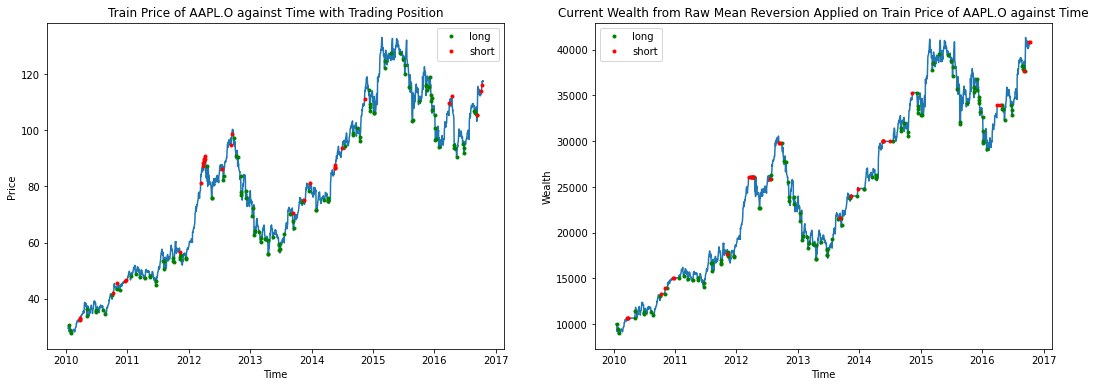

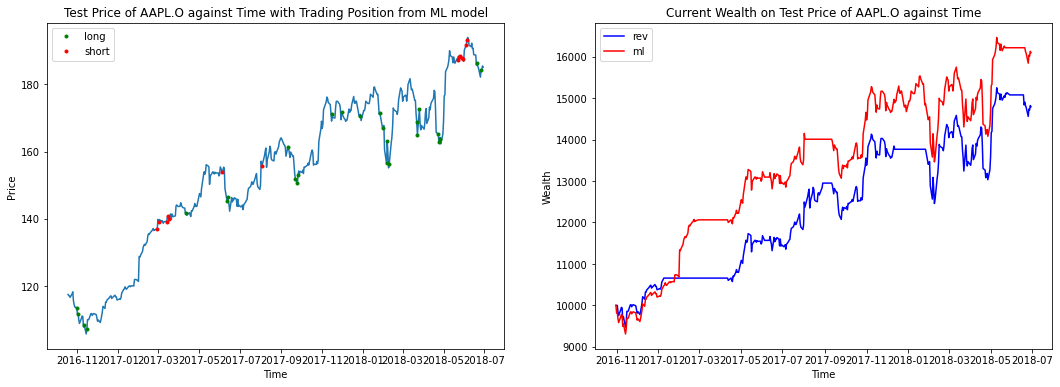


Evaluation metrics on different datasets of AAPL.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
AAPL.O train        3.080118           0.231601               0.244115   
       test_rev     0.479049           0.265415               0.175727   
       test_ml      0.609537           0.331425               0.182484   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
AAPL.O train         0.948739     -0.441403      0.524692   
       test_rev      1.510386     -0.118336      2.242893   
       test_ml       1.816189     -0.133466      2.483216   

                 Profit diff in ML (vs MR)  
Stock  Model                                
AAPL.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.130488


Overall score of strategy on AAPL.O


precision    recall  f1-score  support
Stock  Measure                                             
AAPL.O short          0.500000  0.500000  0.500000       14
       keep           0.970899  0.963255  0.967062      381
       long           0.740741  0.833333  0.784314       24
       accuracy            NaN       NaN  0.940334      419
       macro avg      0.737213  0.765529  0.750459      419
       weighted avg   0.941982  0.940334  0.940988      419

In [32]:
aapl_enhance_model = EnhancedMeanReversion().fit('AAPL.O', train_aapl)
aapl_enhance_pred = aapl_enhance_model.predict(test_aapl)
aapl_enhance_model.evaluate()

##### Observation
The enhanced mean reversion logistic regression model performs better than the raw enhanced mean reversion on AAPL.O test data.

#### MSFT.O

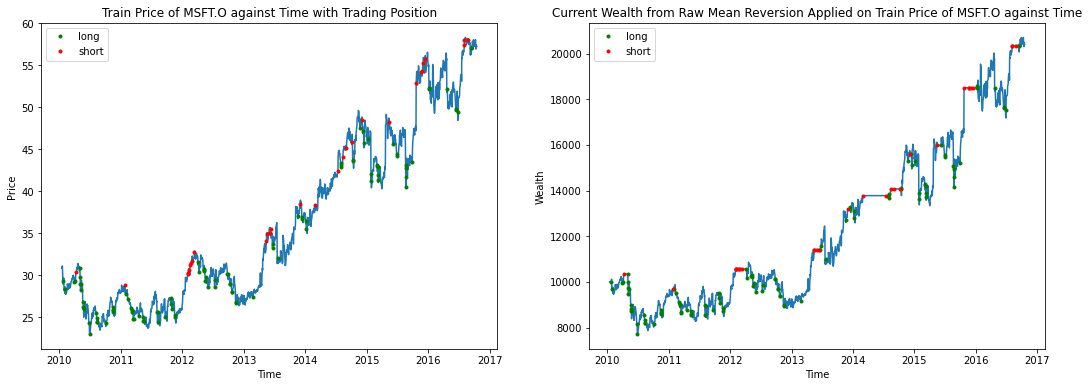

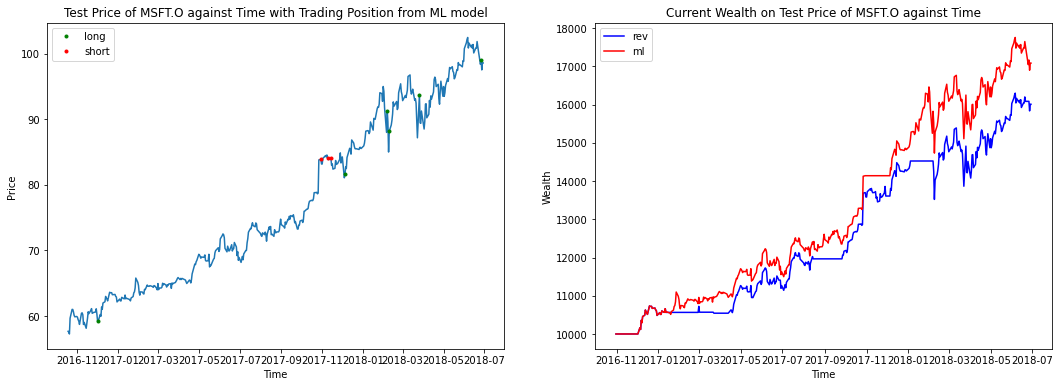


Evaluation metrics on different datasets of MSFT.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
MSFT.O train        1.041379           0.111513               0.217487   
       test_rev     0.600786           0.327066               0.164817   
       test_ml      0.708398           0.380024               0.182047   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
MSFT.O train         0.512735     -0.254136      0.438794   
       test_rev      1.984422     -0.099083      3.300920   
       test_ml       2.087503     -0.105096      3.615975   

                 Profit diff in ML (vs MR)  
Stock  Model                                
MSFT.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.107612


Overall score of strategy on MSFT.O


precision    recall  f1-score  support
Stock  Measure                                             
MSFT.O short          0.000000  0.000000  0.000000        9
       keep           0.934146  0.992228  0.962312      386
       long           1.000000  0.250000  0.400000       24
       accuracy            NaN       NaN  0.928401      419
       macro avg      0.644715  0.414076  0.454104      419
       weighted avg   0.917853  0.928401  0.909433      419

In [33]:
msft_enhance_model = EnhancedMeanReversion().fit('MSFT.O', train_msft)
msft_enhance_pred = msft_enhance_model.predict(test_msft)
msft_enhance_model.evaluate()

##### Observation
The enhanced mean reversion logistic regression model performs better than the raw enhanced mean reversion on MSFT.O test data.

#### INTC.O

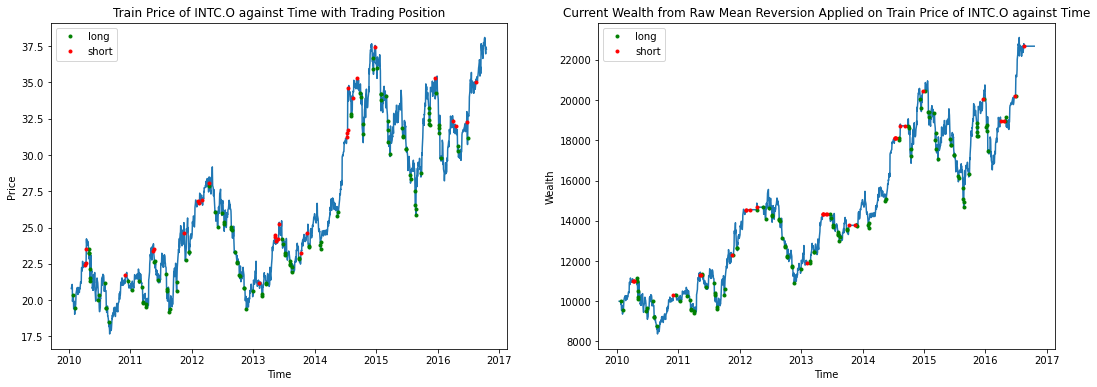

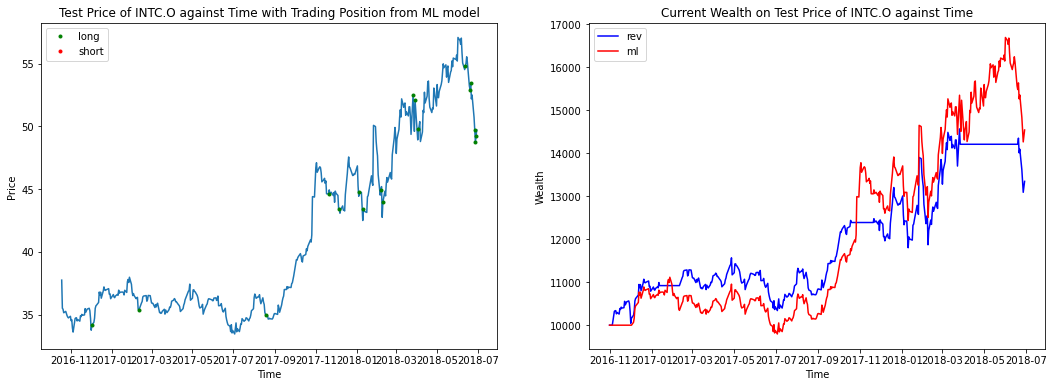


Evaluation metrics on different datasets of INTC.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
INTC.O train        1.267932           0.128979               0.216162   
       test_rev     0.334538           0.189537               0.195201   
       test_ml      0.454060           0.252513               0.236002   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
INTC.O train         0.596678     -0.299348      0.430867   
       test_rev      0.970983     -0.146064      1.297636   
       test_ml       1.069959     -0.146113      1.728200   

                 Profit diff in ML (vs MR)  
Stock  Model                                
INTC.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.119522


Overall score of strategy on INTC.O


precision    recall  f1-score  support
Stock  Measure                                             
INTC.O short          1.000000  0.000000  0.000000        6
       keep           0.952618  0.982005  0.967089      389
       long           0.611111  0.458333  0.523810       24
       accuracy            NaN       NaN  0.937947      419
       macro avg      0.854577  0.480113  0.496966      419
       weighted avg   0.933736  0.937947  0.927849      419

In [34]:
intc_enhance_model = EnhancedMeanReversion().fit('INTC.O', train_intc)
intc_enhance_pred = intc_enhance_model.predict(test_intc)
intc_enhance_model.evaluate()

##### Observation
The enhanced mean reversion logistic regression model performs better than the raw enhanced mean reversion on INTC.O test data.

#### AMZN.O

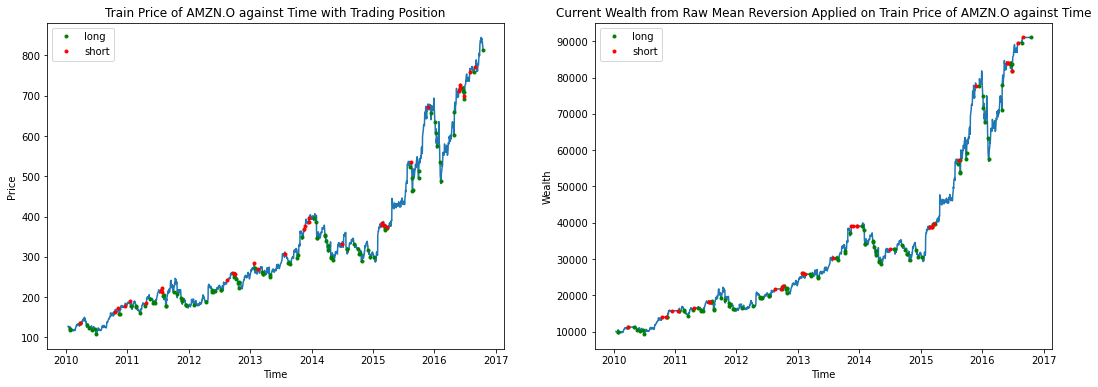

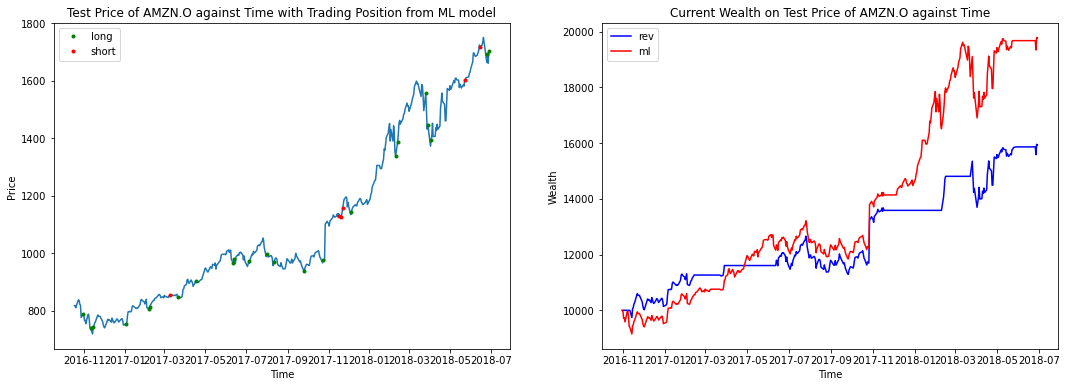


Evaluation metrics on different datasets of AMZN.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
AMZN.O train        8.104518           0.387114               0.301389   
       test_rev     0.594274           0.323817               0.186875   
       test_ml      0.977381           0.506878               0.222354   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
AMZN.O train         1.284433     -0.304805      1.270037   
       test_rev      1.732800     -0.108229      2.991949   
       test_ml       2.279603     -0.138458      3.660883   

                 Profit diff in ML (vs MR)  
Stock  Model                                
AMZN.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.383107


Overall score of strategy on AMZN.O


precision    recall  f1-score  support
Stock  Measure                                             
AMZN.O short          0.333333  0.111111  0.166667       18
       keep           0.951282  0.978892  0.964889      379
       long           0.826087  0.863636  0.844444       22
       accuracy            NaN       NaN  0.935561      419
       macro avg      0.703567  0.651213  0.658667      419
       weighted avg   0.918162  0.935561  0.924274      419

In [35]:
amzn_enhance_model = EnhancedMeanReversion().fit('AMZN.O', train_amzn)
amzn_enhance_pred = amzn_enhance_model.predict(test_amzn)
amzn_enhance_model.evaluate()

##### Observation
The enhanced mean reversion logistic regression model performs much more better than the raw enhanced mean reversion on AMZN.O test data.

#### GS.N

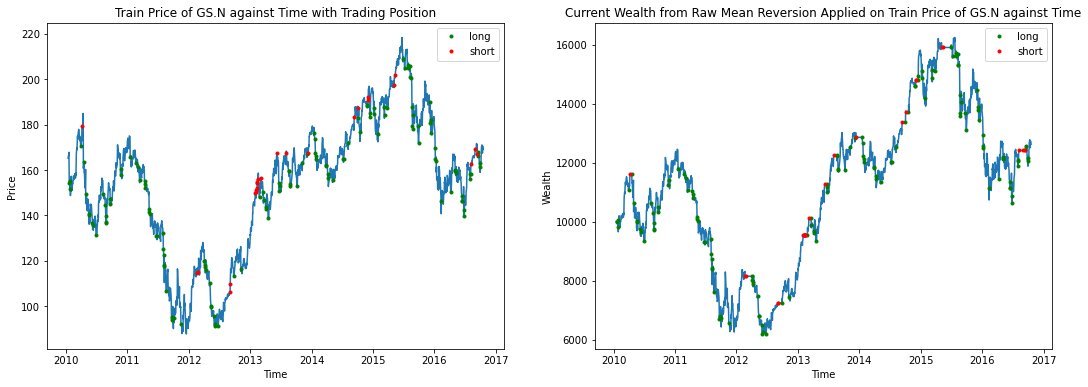

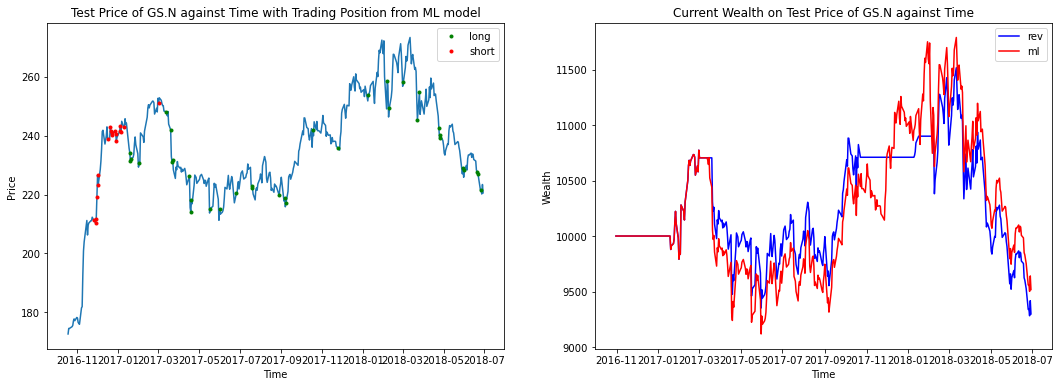


Evaluation metrics on different datasets of GS.N


Base Profit  Annualized Return  Annualized Volatility  \
Stock Model                                                             
GS.N  train        0.262523           0.035138               0.252617   
      test_rev    -0.070200          -0.042831               0.175689   
      test_ml     -0.048203          -0.029276               0.197911   

                Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock Model                                                
GS.N  train         0.139097     -0.503051      0.069851   
      test_rev     -0.243791     -0.194025     -0.220751   
      test_ml      -0.147924     -0.194049     -0.150868   

                Profit diff in ML (vs MR)  
Stock Model                                
GS.N  train                           NaN  
      test_rev                        NaN  
      test_ml                    0.021997


Overall score of strategy on GS.N


precision    recall  f1-score  support
Stock Measure                                             
GS.N  short          0.263158  0.500000  0.344828       10
      keep           0.975342  0.941799  0.958277      378
      long           0.771429  0.870968  0.818182       31
      accuracy            NaN       NaN  0.926014      419
      macro avg      0.669976  0.770922  0.707096      419
      weighted avg   0.943259  0.926014  0.933271      419

In [36]:
gsn_enhance_model = EnhancedMeanReversion().fit('GS.N', train_gsn)
gsn_enhance_pred = gsn_enhance_model.predict(test_gsn)
gsn_enhance_model.evaluate()

##### Observation
The enhanced mean reversion logistic regression model performs slightly better than the raw enhanced mean reversion on GS.N test data.

However, both of the model gave negative yield on the GS.N test data.

GS.N prices had a relatively larger fluctuation and sharper decreasing trends which spanned longer than the strategy windows, which may explain the less effectiveness of the enhanced startegy on it.

#### Cross comparison between different stocks

In [37]:
stock_enhance_models = [aapl_enhance_model, msft_enhance_model, intc_enhance_model, amzn_enhance_model, gsn_enhance_model]
e_mets, e_overalls, e_mets_avg, e_overalls_avg = MeanReversion.compare(stock_enhance_models)


Evaluation metrics on different datasets of different stocks


Base Profit  Annualized Return  Annualized Volatility  \
Model    Stock                                                           
test_ml  AMZN.O     0.977381           0.506878               0.222354   
         MSFT.O     0.708398           0.380024               0.182047   
         AAPL.O     0.609537           0.331425               0.182484   
         INTC.O     0.454060           0.252513               0.236002   
         GS.N      -0.048203          -0.029276               0.197911   
test_rev MSFT.O     0.600786           0.327066               0.164817   
         AMZN.O     0.594274           0.323817               0.186875   
         AAPL.O     0.479049           0.265415               0.175727   
         INTC.O     0.334538           0.189537               0.195201   
         GS.N      -0.070200          -0.042831               0.175689   
train    AMZN.O     8.104518           0.387114               0.301389   
         AAPL.O     3.080118           0.231601               0.244115   
         INTC.O     1.267932           0.128979               0.216162   
         MSFT.O     1.041379           0.111513               0.217487   
         GS.N       0.262523           0.035138               0.252617   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Model    Stock                                              
test_ml  AMZN.O      2.279603     -0.138458      3.660883   
         MSFT.O      2.087503     -0.105096      3.615975   
         AAPL.O      1.816189     -0.133466      2.483216   
         INTC.O      1.069959     -0.146113      1.728200   
         GS.N       -0.147924     -0.194049     -0.150868   
test_rev MSFT.O      1.984422     -0.099083      3.300920   
         AMZN.O      1.732800     -0.108229      2.991949   
         AAPL.O      1.510386     -0.118336      2.242893   
         INTC.O      0.970983     -0.146064      1.297636   
         GS.N       -0.243791     -0.194025     -0.220751   
train    AMZN.O      1.284433     -0.304805      1.270037   
         AAPL.O      0.948739     -0.441403      0.524692   
         INTC.O      0.596678     -0.299348      0.430867   
         MSFT.O      0.512735     -0.254136      0.438794   
         GS.N        0.139097     -0.503051      0.069851   

                 Profit diff in ML (vs MR)  
Model    Stock                              
test_ml  AMZN.O                   0.383107  
         MSFT.O                   0.107612  
         AAPL.O                   0.130488  
         INTC.O                   0.119522  
         GS.N                     0.021997  
test_rev MSFT.O                        NaN  
         AMZN.O                        NaN  
         AAPL.O                        NaN  
         INTC.O                        NaN  
         GS.N                          NaN  
train    AMZN.O                        NaN  
         AAPL.O                        NaN  
         INTC.O                        NaN  
         MSFT.O                        NaN  
         GS.N                          NaN


Overall score of strategy on different stocks


precision    recall  f1-score  support
Measure      Stock                                         
accuracy     AMZN.O        NaN       NaN  0.935561      419
             AAPL.O        NaN       NaN  0.940334      419
             INTC.O        NaN       NaN  0.937947      419
             GS.N          NaN       NaN  0.926014      419
             MSFT.O        NaN       NaN  0.928401      419
keep         AAPL.O   0.970899  0.963255  0.967062      381
             INTC.O   0.952618  0.982005  0.967089      389
             MSFT.O   0.934146  0.992228  0.962312      386
             GS.N     0.975342  0.941799  0.958277      378
             AMZN.O   0.951282  0.978892  0.964889      379
long         INTC.O   0.611111  0.458333  0.523810       24
             AMZN.O   0.826087  0.863636  0.844444       22
             GS.N     0.771429  0.870968  0.818182       31
             AAPL.O   0.740741  0.833333  0.784314       24
             MSFT.O   1.000000  0.250000  0.400000       24
macro avg    GS.N     0.669976  0.770922  0.707096      419
             AAPL.O   0.737213  0.765529  0.750459      419
             INTC.O   0.854577  0.480113  0.496966      419
             AMZN.O   0.703567  0.651213  0.658667      419
             MSFT.O   0.644715  0.414076  0.454104      419
short        GS.N     0.263158  0.500000  0.344828       10
             AAPL.O   0.500000  0.500000  0.500000       14
             INTC.O   1.000000  0.000000  0.000000        6
             MSFT.O   0.000000  0.000000  0.000000        9
             AMZN.O   0.333333  0.111111  0.166667       18
weighted avg INTC.O   0.933736  0.937947  0.927849      419
             AMZN.O   0.918162  0.935561  0.924274      419
             MSFT.O   0.917853  0.928401  0.909433      419
             AAPL.O   0.941982  0.940334  0.940988      419
             GS.N     0.943259  0.926014  0.933271      419


Average performance on

Evaluation metrics


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Profit diff in ML (vs MR)
Model,,,,,,,
train,2.751294,0.178869,0.246354,0.696337,-0.360549,0.546848,NaN
test_ml,0.540235,0.288313,0.204160,1.421066,-0.143436,2.267481,0.152545
test_rev,0.387689,0.212601,0.179662,1.190960,-0.133148,1.922529,NaN



Overall machine learning model score


,precision,recall,f1-score,support
Measure,,,,
accuracy,NaN,NaN,0.933652,419.0
keep,0.956858,0.971636,0.963926,382.6
long,0.789873,0.655254,0.674150,25.0
macro avg,0.722010,0.616371,0.613458,419.0
short,0.419298,0.222222,0.202299,11.4
weighted avg,0.930998,0.933652,0.927163,419.0


##### Observation
The enhanced mean reversion machine learning model performs much better than raw enhanced mean reversion on the test data.

Most of the stocks have better performance when using the enhanced mean reversion machine learning model, except for GS.N.

The average base profit is +54.02%, annualized return is +28.83%, annualized volatility is 20.42% and average accuracy of model 
is 93.37%.

### Evaluation of the effectiveness of Enhanced model w.r.t Basic Model

#### AAPL.O

Comparison of Wealth from


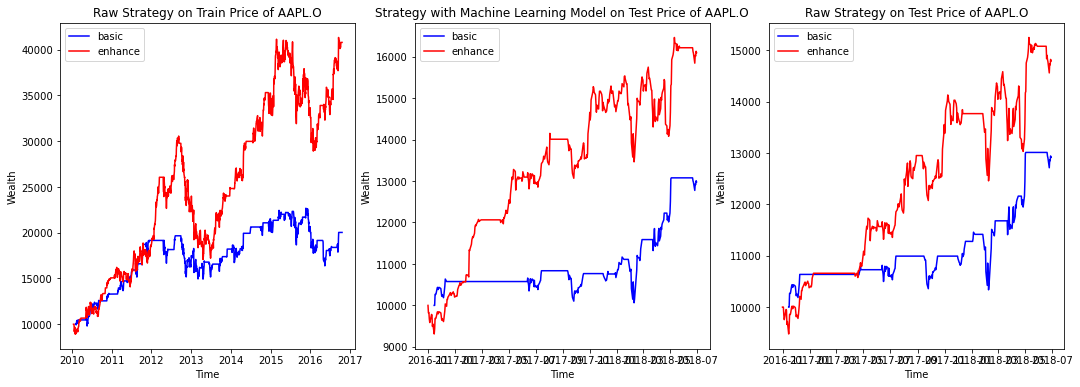


Enhancement on metrics for AAPL.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
AAPL.O train        2.077063           0.122529               0.051727   
       test_rev     0.187578           0.094721               0.050294   
       test_ml      0.311609           0.157128               0.054924   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
AAPL.O train         0.381804     -0.163569      0.132115   
       test_rev      0.149543     -0.020414      0.499738   
       test_ml       0.449797     -0.034625      0.719803   

                 Profit diff in ML (vs MR)  
Stock  Model                                
AAPL.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.124031


Enhancement on performance scores for AAPL.O


precision    recall  f1-score  support
Stock  Measure                                             
AAPL.O short         -0.428571 -0.291304 -0.354460     -101
       keep           0.085714  0.014842  0.051353      129
       long          -0.112918  0.000000 -0.059060      -18
       accuracy            NaN       NaN  0.047914       10
       macro avg     -0.151925 -0.092154 -0.120722       10
       weighted avg   0.047835  0.047914  0.049929       10

In [38]:
aapl_performance_growth = EnhancedMeanReversion.evaluate_enhancement('AAPL.O', aapl_basic_model, aapl_enhance_model)

##### Observation
The all enhanced models perform better than basic models on AAPL.O stock.

#### MSFT.O

Comparison of Wealth from


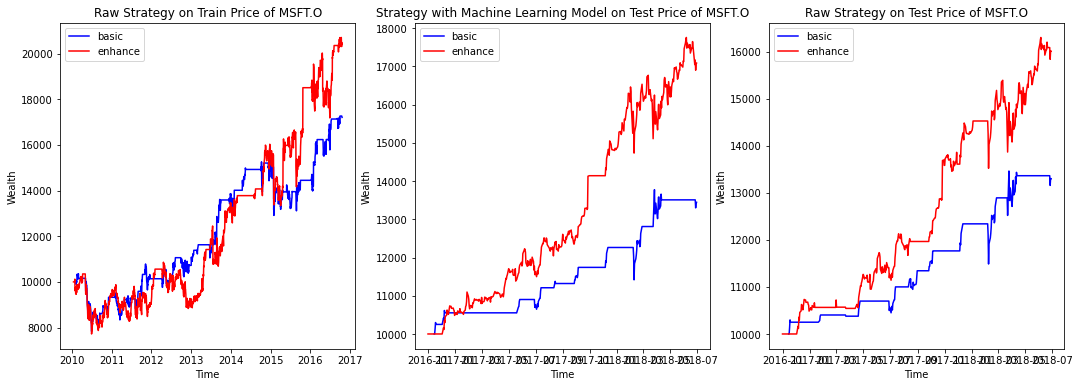


Enhancement on metrics for MSFT.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
MSFT.O train        0.320999           0.027302               0.055528   
       test_rev     0.270888           0.135031               0.043738   
       test_ml      0.364014           0.180005               0.064923   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
MSFT.O train        -0.007218     -0.010320      0.093407   
       test_rev      0.398390     -0.029939      0.523627   
       test_ml       0.379749     -0.036032      0.719836   

                 Profit diff in ML (vs MR)  
Stock  Model                                
MSFT.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.093126


Enhancement on performance scores for MSFT.O


precision    recall  f1-score  support
Stock  Measure                                             
MSFT.O short         -0.834711 -0.848739 -0.841667     -110
       keep           0.023366  0.078049  0.049835      118
       long           0.157895 -0.477273 -0.380488        2
       accuracy            NaN       NaN  0.043315       10
       macro avg     -0.217817 -0.415988 -0.390773       10
       weighted avg   0.032899  0.043315  0.024658       10

In [39]:
msft_performance_growth = EnhancedMeanReversion.evaluate_enhancement('MSFT.O', msft_basic_model, msft_enhance_model)

##### Observation
The all enhanced model perform better than basic model on MSFT.O stock.

#### INTC.O

Comparison of Wealth from


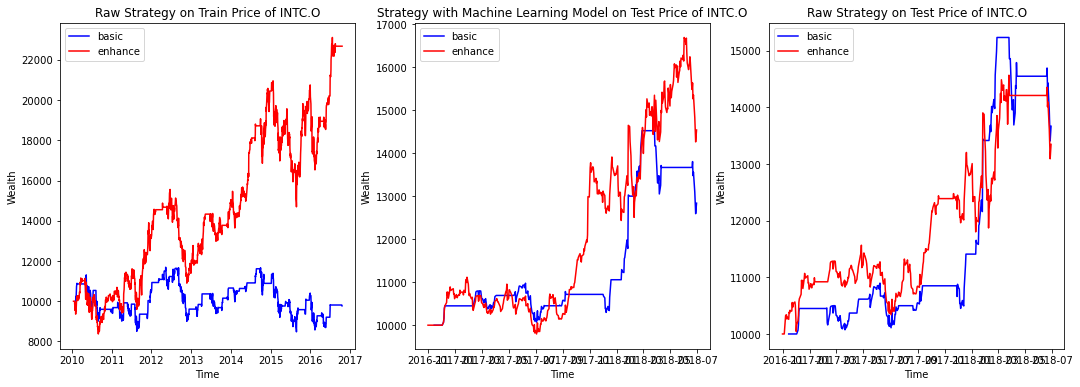


Enhancement on metrics for INTC.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
INTC.O train        1.290805           0.132421               0.045575   
       test_rev    -0.032002          -0.022628               0.036389   
       test_ml      0.170224           0.086088               0.084285   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
INTC.O train         0.616856     -0.024710      0.443400   
       test_rev     -0.364964     -0.026149     -0.471678   
       test_ml      -0.026980     -0.013165      0.476398   

                 Profit diff in ML (vs MR)  
Stock  Model                                
INTC.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.202226


Enhancement on performance scores for INTC.O


precision    recall  f1-score  support
Stock  Measure                                             
INTC.O short          0.099010 -0.850467 -0.875000     -101
       keep           0.082248  0.030588  0.057998      142
       long          -0.336257 -0.196212 -0.250384      -31
       accuracy            NaN       NaN  0.052862       10
       macro avg     -0.051666 -0.338697 -0.355795       10
       weighted avg   0.045000  0.052862  0.045817       10

In [40]:
intc_performance_growth = EnhancedMeanReversion.evaluate_enhancement('INTC.O', intc_basic_model, intc_enhance_model)

##### Observation
The enhanced models perform better than basic models on INTC.O stock, except for raw strategies applied on the test data.

The enhanced strategy has a higher constraint for short signal, while most of the test data price in the evaluation windows has only little increases that were unable to hit the short target.

The possible profit obtained from the little increasing intervals were given up by the enhanced strategy.

#### AMZN.O

Comparison of Wealth from


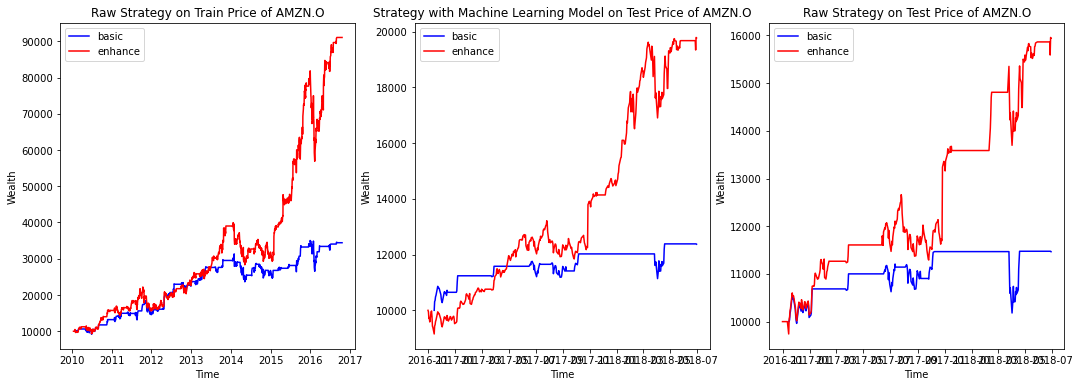


Enhancement on metrics for AMZN.O


Base Profit  Annualized Return  Annualized Volatility  \
Stock  Model                                                             
AMZN.O train        5.662849           0.184873               0.077755   
       test_rev     0.447758           0.235923               0.070820   
       test_ml      0.740116           0.366708               0.112529   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock  Model                                                
AMZN.O train         0.380091     -0.059060      0.447066   
       test_rev      0.975458      0.004007      2.208838   
       test_ml       1.003290     -0.064683      1.760917   

                 Profit diff in ML (vs MR)  
Stock  Model                                
AMZN.O train                           NaN  
       test_rev                        NaN  
       test_ml                    0.292358


Enhancement on performance scores for AMZN.O


precision    recall  f1-score  support
Stock  Measure                                             
AMZN.O short         -0.529680 -0.782506 -0.711382     -123
       keep           0.063315  0.075938  0.069492      142
       long          -0.037549  0.250733  0.127463       -9
       accuracy            NaN       NaN  0.057810       10
       macro avg     -0.167972 -0.151945 -0.171476       10
       weighted avg   0.040642  0.057810  0.048381       10

In [41]:
amzn_performance_growth = EnhancedMeanReversion.evaluate_enhancement('AMZN.O', amzn_basic_model, amzn_enhance_model)

##### Observation
The all enhanced model perform much better than basic model on AMZN.O stock.

#### GS.N

Comparison of Wealth from


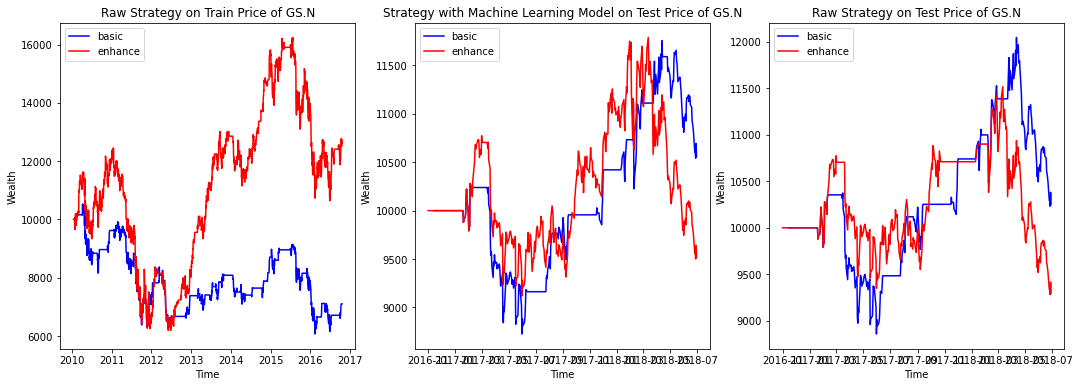


Enhancement on metrics for GS.N


Base Profit  Annualized Return  Annualized Volatility  \
Stock Model                                                             
GS.N  train        0.552084           0.084810               0.048828   
      test_rev    -0.095221          -0.058175               0.021462   
      test_ml     -0.104234          -0.063437               0.046349   

                Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Stock Model                                                
GS.N  train         0.382835     -0.079475      0.187117   
      test_rev     -0.343275     -0.043520     -0.322696   
      test_ml      -0.373315     -0.042912     -0.376894   

                Profit diff in ML (vs MR)  
Stock Model                                
GS.N  train                           NaN  
      test_rev                        NaN  
      test_ml                   -0.009013


Enhancement on performance scores for GS.N


precision    recall  f1-score  support
Stock Measure                                             
GS.N  short         -0.608637 -0.418919 -0.549909      -64
      keep           0.048603  0.011652  0.029837      106
      long          -0.073399  0.093190  0.008264      -32
      accuracy            NaN       NaN  0.021369       10
      macro avg     -0.211144 -0.104692 -0.170603       10
      weighted avg   0.039077  0.021369  0.029186       10

In [42]:
gsn_performance_growth = EnhancedMeanReversion.evaluate_enhancement('GS.N', gsn_basic_model, gsn_enhance_model)

##### Observation
The enhanced models performs worse than basic models on GS.N test data.

The enhancement direction is to optimize stock prices with an overall increasing trend (average trends).

Although GS.N has quite stable prices, it had larger portion of fluctuating and decreasing trends during the evaluation windows, which was slightly deviated from the enhanced model.

In [43]:
performance_growths = [aapl_performance_growth, msft_performance_growth, intc_performance_growth, \
                       amzn_performance_growth, gsn_performance_growth]
p_mets, p_overalls, p_mets_avg, p_overalls_avg = EnhancedMeanReversion.compare_enhancement(performance_growths)

Comparison on performance growths:

Evaluation metrics on different datasets of different stocks


Base Profit  Annualized Return  Annualized Volatility  \
Model    Stock                                                           
test_ml  AMZN.O     0.740116           0.366708               0.112529   
         MSFT.O     0.364014           0.180005               0.064923   
         AAPL.O     0.311609           0.157128               0.054924   
         INTC.O     0.170224           0.086088               0.084285   
         GS.N      -0.104234          -0.063437               0.046349   
test_rev AMZN.O     0.447758           0.235923               0.070820   
         MSFT.O     0.270888           0.135031               0.043738   
         AAPL.O     0.187578           0.094721               0.050294   
         INTC.O    -0.032002          -0.022628               0.036389   
         GS.N      -0.095221          -0.058175               0.021462   
train    AMZN.O     5.662849           0.184873               0.077755   
         AAPL.O     2.077063           0.122529               0.051727   
         INTC.O     1.290805           0.132421               0.045575   
         GS.N       0.552084           0.084810               0.048828   
         MSFT.O     0.320999           0.027302               0.055528   

                 Sharpe Ratio  Max Drawdown  Calmar Ratio  \
Model    Stock                                              
test_ml  AMZN.O      1.003290     -0.064683      1.760917   
         MSFT.O      0.379749     -0.036032      0.719836   
         AAPL.O      0.449797     -0.034625      0.719803   
         INTC.O     -0.026980     -0.013165      0.476398   
         GS.N       -0.373315     -0.042912     -0.376894   
test_rev AMZN.O      0.975458      0.004007      2.208838   
         MSFT.O      0.398390     -0.029939      0.523627   
         AAPL.O      0.149543     -0.020414      0.499738   
         INTC.O     -0.364964     -0.026149     -0.471678   
         GS.N       -0.343275     -0.043520     -0.322696   
train    AMZN.O      0.380091     -0.059060      0.447066   
         AAPL.O      0.381804     -0.163569      0.132115   
         INTC.O      0.616856     -0.024710      0.443400   
         GS.N        0.382835     -0.079475      0.187117   
         MSFT.O     -0.007218     -0.010320      0.093407   

                 Profit diff in ML (vs MR)  
Model    Stock                              
test_ml  AMZN.O                   0.292358  
         MSFT.O                   0.093126  
         AAPL.O                   0.124031  
         INTC.O                   0.202226  
         GS.N                    -0.009013  
test_rev AMZN.O                        NaN  
         MSFT.O                        NaN  
         AAPL.O                        NaN  
         INTC.O                        NaN  
         GS.N                          NaN  
train    AMZN.O                        NaN  
         AAPL.O                        NaN  
         INTC.O                        NaN  
         GS.N                          NaN  
         MSFT.O                        NaN


Overall score of strategy on different stocks


precision    recall  f1-score  support
Measure      Stock                                         
accuracy     AMZN.O        NaN       NaN  0.057810       10
             AAPL.O        NaN       NaN  0.047914       10
             INTC.O        NaN       NaN  0.052862       10
             GS.N          NaN       NaN  0.021369       10
             MSFT.O        NaN       NaN  0.043315       10
keep         AAPL.O   0.085714  0.014842  0.051353      129
             INTC.O   0.082248  0.030588  0.057998      142
             MSFT.O   0.023366  0.078049  0.049835      118
             GS.N     0.048603  0.011652  0.029837      106
             AMZN.O   0.063315  0.075938  0.069492      142
long         INTC.O  -0.336257 -0.196212 -0.250384      -31
             AMZN.O  -0.037549  0.250733  0.127463       -9
             GS.N    -0.073399  0.093190  0.008264      -32
             AAPL.O  -0.112918  0.000000 -0.059060      -18
             MSFT.O   0.157895 -0.477273 -0.380488        2
macro avg    GS.N    -0.211144 -0.104692 -0.170603       10
             AAPL.O  -0.151925 -0.092154 -0.120722       10
             INTC.O  -0.051666 -0.338697 -0.355795       10
             AMZN.O  -0.167972 -0.151945 -0.171476       10
             MSFT.O  -0.217817 -0.415988 -0.390773       10
short        GS.N    -0.608637 -0.418919 -0.549909      -64
             AAPL.O  -0.428571 -0.291304 -0.354460     -101
             INTC.O   0.099010 -0.850467 -0.875000     -101
             MSFT.O  -0.834711 -0.848739 -0.841667     -110
             AMZN.O  -0.529680 -0.782506 -0.711382     -123
weighted avg INTC.O   0.045000  0.052862  0.045817       10
             AMZN.O   0.040642  0.057810  0.048381       10
             MSFT.O   0.032899  0.043315  0.024658       10
             AAPL.O   0.047835  0.047914  0.049929       10
             GS.N     0.039077  0.021369  0.029186       10


Average performance on

Evaluation metrics


,Base Profit,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Profit diff in ML (vs MR)
Model,,,,,,,
test_ml,0.296346,0.145298,0.072602,0.286508,-0.038283,0.660012,0.140546
test_rev,0.155800,0.076975,0.044541,0.163030,-0.023203,0.487566,NaN
train,1.980760,0.110387,0.055883,0.350874,-0.067426,0.260621,NaN



Overall machine learning model score


,precision,recall,f1-score,support
Measure,,,,
accuracy,NaN,NaN,0.044654,10.0
keep,0.060649,0.042214,0.051703,127.4
long,-0.080446,-0.065912,-0.110841,-17.6
macro avg,-0.160105,-0.220695,-0.241874,10.0
short,-0.460518,-0.638387,-0.666484,-99.8
weighted avg,0.041091,0.044654,0.039594,10.0


##### Observation
The enhanced strategy performs much better than the basic strategy on the test data.

Most of the stocks have better performance when using the enhanced strategy, except for GS.N.

The difference (enhanced model w.r.t basic model) in average base profit is +29.63%, in annualized return is +14.53% and in average accuracy of model is 4.47%. 

It, however, resulted a higher volatility in the enhanced strategy with an increase 7.26% of annualized volatility in the enhanced model with respect to the basic model.

### Comparison between strategies

- Profits for trading metrics

- Accuracy and precision for machine learning model

#### For strategy 1


Performance metrics for basic model strat 1:


,AMZN.O,Average,GS.N,MSFT.O,INTC.O,AAPL.O
Profit,4.822722,2.797202,2.536753,2.523972,2.298004,1.804559
Accuracy,0.662763,0.696487,0.718970,0.714286,0.695550,0.690867



Precision evaluation for basic model strat 1:


,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,Average
short,0.508475,0.521127,0.557377,0.509434,0.542857,0.527854
keep,0.749186,0.778157,0.739414,0.841346,0.780822,0.777785
long,0.573770,0.634921,0.610169,0.477876,0.630769,0.585501




Performance metrics for enhanced model strat 1:


,AAPL.O,INTC.O,MSFT.O,Average,GS.N,AMZN.O
Profit,0.409985,0.361680,0.298659,0.273106,0.266904,0.028301
Accuracy,0.265882,0.277647,0.240000,0.303529,0.324706,0.409412



Precision evaluation for enhanced model strat 1:


,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,Average
short,0.493151,0.789474,0.402174,0.635135,0.487805,0.561548
keep,0.227799,0.232416,0.269531,0.294393,0.291971,0.263222
long,0.193548,0.139241,0.155844,0.467153,0.260870,0.243331




Enhancement evaluation for strat 1:


,AAPL.O,INTC.O,MSFT.O,GS.N,Average,AMZN.O
Profit,-1.394574,-1.936324,-2.225313,-2.269849,-2.524096,-4.794421
Accuracy,-0.424984,-0.417903,-0.474286,-0.394264,-0.392958,-0.253352



Precision enhancement for strat 1:


,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,Average
short,-0.015324,0.268347,-0.155203,0.125701,-0.055052,0.033694
keep,-0.521386,-0.545741,-0.469882,-0.546954,-0.488851,-0.514563
long,-0.380222,-0.495680,-0.454325,-0.010723,-0.369900,-0.342170


Text(0.5, 1.0, 'Accuracy evaluation for strat 1')

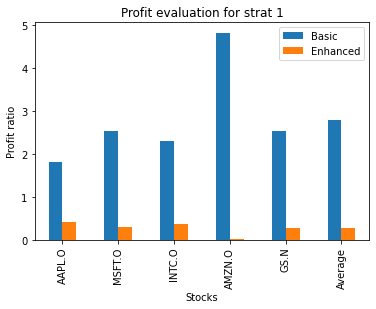

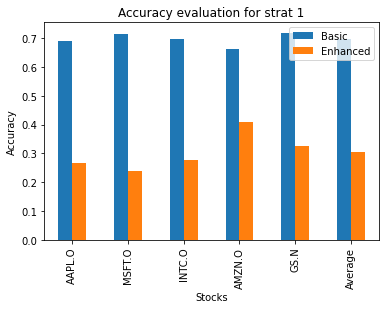

In [44]:
def create_strat1_df(met, score):
    """
    Create a DataFrame for strategy 1 performance metrics.

    Parameters:
    - met (dict): A dictionary containing trading metrics for different stocks.
    - score (dict): A dictionary containing accuracy scores for different stocks.

    Returns:
    - df (pd.DataFrame): A DataFrame containing profit and accuracy metrics for the strategy.
    """
    df = pd.DataFrame(met, index=['Profit'])
    df = pd.concat([df, pd.DataFrame(score, index=['Accuracy'])])
    df.loc['Profit'] = df.loc['Profit'] / 100
    df['Average'] = df.mean(axis=1)
    return df

def create_strat1_precision(raw):
    """
    Create a DataFrame for strategy 1 precision evaluation.

    Parameters:
    - raw (dict): A dictionary containing raw precision values for different stocks.

    Returns:
    - df (pd.DataFrame): A DataFrame containing precision values for short, keep, long, and their averages.
    """
    k1, k2, k3 = dict(list(raw.values())[0]).keys()
    df = pd.DataFrame(raw).rename(index={k1:'short', k2:'keep', k3:'long'})
    df['Average'] = df.mean(axis=1)
    return df

# Example usage of the functions
basic_met_df = create_strat1_df(basic_perf_all, basic_accuracy_all)
enhanced_met_df = create_strat1_df(enhanced_perf_all, enhanced_accuracy_all)
performance_met_df = enhanced_met_df - basic_met_df

basic_prec_df = create_strat1_precision(basic_precision_all)
enhanced_prec_df = create_strat1_precision(enhanced_precision_all)
performance_prec_df = enhanced_prec_df - basic_prec_df

# Displaying the results
print('\nPerformance metrics for basic model strat 1:')
display(basic_met_df.sort_values(by='Profit', ascending=False, axis=1))

print('\nPrecision evaluation for basic model strat 1:')
display(basic_prec_df)

print('\n\nPerformance metrics for enhanced model strat 1:')
display(enhanced_met_df.sort_values(by='Profit', ascending=False, axis=1))

print('\nPrecision evaluation for enhanced model strat 1:')
display(enhanced_prec_df)

print('\n\nEnhancement evaluation for strat 1:')
display(performance_met_df.sort_values(by='Profit', ascending=False, axis=1))

print('\nPrecision enhancement for strat 1:')
display(performance_prec_df)

# Plotting combined results
combined_profit_s1 = pd.DataFrame(
    {'Basic': basic_met_df.transpose()['Profit'],'Enhanced': enhanced_met_df.transpose()['Profit']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_profit_s1.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Profit ratio')
plt.title('Profit evaluation for strat 1')

combined_accuracy_s1 = pd.DataFrame(
    {'Basic': basic_met_df.transpose()['Accuracy'],'Enhanced': enhanced_met_df.transpose()['Accuracy']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_accuracy_s1.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Accuracy')
plt.title('Accuracy evaluation for strat 1')

#### For strategy 2


Performance metrics for basic model strat 2:


Stock,MSFT.O,AAPL.O,INTC.O,Average,AMZN.O,GS.N
Profit,0.344384,0.297928,0.283836,0.243889,0.237265,0.056031
Accuracy,0.885086,0.892421,0.885086,0.888998,0.877751,0.904645



Precision evaluation for basic model strat 2:


Stock,GS.N,AAPL.O,INTC.O,MSFT.O,AMZN.O,Average
short,0.871795,0.928571,0.900990,0.834711,0.863014,0.879816
keep,0.926740,0.885185,0.870370,0.910781,0.887967,0.896209
long,0.844828,0.853659,0.947368,0.842105,0.863636,0.870319




Performance metrics for enhanced model strat 2:


Stock,AMZN.O,MSFT.O,AAPL.O,Average,INTC.O,GS.N
Profit,0.977381,0.708398,0.609537,0.540235,0.454060,-0.048203
Accuracy,0.935561,0.928401,0.940334,0.933652,0.937947,0.926014



Precision evaluation for enhanced model strat 2:


Stock,GS.N,AAPL.O,INTC.O,MSFT.O,AMZN.O,Average
short,0.263158,0.500000,1.000000,0.000000,0.333333,0.419298
keep,0.975342,0.970899,0.952618,0.934146,0.951282,0.956858
long,0.771429,0.740741,0.611111,1.000000,0.826087,0.789873




Enhancement evaluation for strat 2:


Stock,AMZN.O,MSFT.O,AAPL.O,Average,INTC.O,GS.N
Profit,0.740116,0.364014,0.311609,0.296346,0.170224,-0.104234
Accuracy,0.057810,0.043315,0.047914,0.044654,0.052862,0.021369



Precision enhancement for strat 2:


Stock,GS.N,AAPL.O,INTC.O,MSFT.O,AMZN.O,Average
short,-0.608637,-0.428571,0.099010,-0.834711,-0.529680,-0.460518
keep,0.048603,0.085714,0.082248,0.023366,0.063315,0.060649
long,-0.073399,-0.112918,-0.336257,0.157895,-0.037549,-0.080446


Text(0.5, 1.0, 'Accuracy evaluation for strat 2')

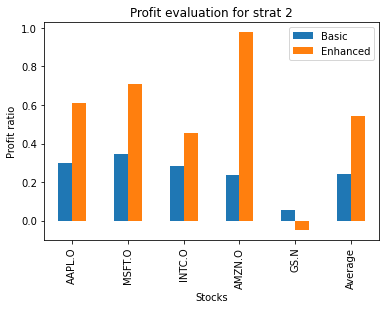

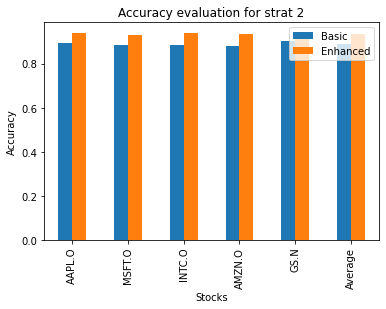

In [45]:
def create_strat2_df(met, score):
    """
    Create a DataFrame for strategy 2 performance metrics.

    Parameters:
    - met (pd.DataFrame): A DataFrame containing trading performance metrics.
    - score (pd.DataFrame): A DataFrame containing accuracy scores.

    Returns:
    - df (pd.DataFrame): A DataFrame containing profit and accuracy metrics for the strategy.
    """
    df = pd.DataFrame(met.loc['test_ml']['Base Profit']).rename(columns={'Base Profit': 'Profit'})
    df['Accuracy'] = score.loc['accuracy']['f1-score']
    df = df.transpose()
    df['Average'] = df.mean(axis=1)
    return df

def create_strat2_precision(score):
    """
    Create a DataFrame for strategy 2 precision evaluation.

    Parameters:
    - score (pd.DataFrame): A DataFrame containing precision scores.

    Returns:
    - df (pd.DataFrame): A DataFrame containing precision values for short, keep, long, and their averages.
    """
    df_short = pd.DataFrame(score.loc['short']['precision']).T
    df_keep = pd.DataFrame(score.loc['keep']['precision']).T
    df_long = pd.DataFrame(score.loc['long']['precision']).T
    df_short.rename({'precision': 'short'}, inplace=True)
    df_keep.rename({'precision': 'keep'}, inplace=True)
    df_long.rename({'precision': 'long'}, inplace=True)
    df = pd.concat([df_short, df_keep, df_long])
    df['Average'] = df.mean(axis=1)
    return df

# Example usage of the functions
basic_met_df2 = create_strat2_df(b_mets, b_overalls)
enhanced_met_df2 = create_strat2_df(e_mets, e_overalls)
performance_met_df2 = create_strat2_df(p_mets, p_overalls)

basic_prec_df2 = create_strat2_precision(b_overalls)
enhanced_prec_df2 = create_strat2_precision(e_overalls)
performance_prec_df2 = create_strat2_precision(p_overalls)

# Displaying the results
print('\nPerformance metrics for basic model strat 2:')
display(basic_met_df2.sort_values(by='Profit', ascending=False, axis=1))

print('\nPrecision evaluation for basic model strat 2:')
display(basic_prec_df2)

print('\n\nPerformance metrics for enhanced model strat 2:')
display(enhanced_met_df2.sort_values(by='Profit', ascending=False, axis=1))

print('\nPrecision evaluation for enhanced model strat 2:')
display(enhanced_prec_df2)

print('\n\nEnhancement evaluation for strat 2:')
display(performance_met_df2.sort_values(by='Profit', ascending=False, axis=1))

print('\nPrecision enhancement for strat 2:')
display(performance_prec_df2)

# Plotting combined results
combined_profit_s2 = pd.DataFrame(
    {'Basic': basic_met_df2.transpose()['Profit'],'Enhanced': enhanced_met_df2.transpose()['Profit']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_profit_s2.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Profit ratio')
plt.title('Profit evaluation for strat 2')

combined_accuracy_s2 = pd.DataFrame(
    {'Basic': basic_met_df2.transpose()['Accuracy'],'Enhanced': enhanced_met_df2.transpose()['Accuracy']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_accuracy_s2.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Accuracy')
plt.title('Accuracy evaluation for strat 2')

##### Observation

The enhanced model has a overall better performance than the basic model, except for the yield in GS.N which has price trend deviated from the average trend.

#### Cross comparison strat 1 vs strat 2

Merge statistics:

Basic model:


,AAPL.O_s1,AAPL.O_s2,AMZN.O_s1,AMZN.O_s2,Average_s1,Average_s2,GS.N_s1,GS.N_s2,INTC.O_s1,INTC.O_s2,MSFT.O_s1,MSFT.O_s2
Profit,1.804559,0.297928,4.822722,0.237265,2.797202,0.243889,2.536753,0.056031,2.298004,0.283836,2.523972,0.344384
Accuracy,0.690867,0.892421,0.662763,0.877751,0.696487,0.888998,0.718970,0.904645,0.695550,0.885086,0.714286,0.885086



Performace evaluation between strategies (strat1 - strat 2):


,AAPL.O,AMZN.O,Average,GS.N,INTC.O,MSFT.O
Profit,1.506631,4.585457,2.553313,2.480722,2.014168,2.179588
Accuracy,-0.201554,-0.214987,-0.192510,-0.185676,-0.189535,-0.170800



Precision


,AAPL.O_s1,AAPL.O_s2,AMZN.O_s1,AMZN.O_s2,Average_s1,Average_s2,GS.N_s1,GS.N_s2,INTC.O_s1,INTC.O_s2,MSFT.O_s1,MSFT.O_s2
short,0.508475,0.928571,0.509434,0.863014,0.527854,0.879816,0.542857,0.871795,0.557377,0.900990,0.521127,0.834711
keep,0.749186,0.885185,0.841346,0.887967,0.777785,0.896209,0.780822,0.926740,0.739414,0.870370,0.778157,0.910781
long,0.573770,0.853659,0.477876,0.863636,0.585501,0.870319,0.630769,0.844828,0.610169,0.947368,0.634921,0.842105



Performace evaluation between strategies (strat1 - strat 2) - precision:


,AAPL.O,AMZN.O,Average,GS.N,INTC.O,MSFT.O
short,-0.420097,-0.353580,-0.351962,-0.328938,-0.343613,-0.313584
keep,-0.136000,-0.046621,-0.118424,-0.145918,-0.130957,-0.132624
long,-0.279888,-0.385760,-0.284818,-0.214058,-0.337199,-0.207185




Enhanced model:


,AAPL.O_s1,AAPL.O_s2,AMZN.O_s1,AMZN.O_s2,Average_s1,Average_s2,GS.N_s1,GS.N_s2,INTC.O_s1,INTC.O_s2,MSFT.O_s1,MSFT.O_s2
Profit,0.409985,0.609537,0.028301,0.977381,0.273106,0.540235,0.266904,-0.048203,0.361680,0.454060,0.298659,0.708398
Accuracy,0.265882,0.940334,0.409412,0.935561,0.303529,0.933652,0.324706,0.926014,0.277647,0.937947,0.240000,0.928401



Performace evaluation between strategies (strat1 - strat 2):


,AAPL.O,AMZN.O,Average,GS.N,INTC.O,MSFT.O
Profit,-0.199552,-0.949080,-0.267129,0.315107,-0.09238,-0.409739
Accuracy,-0.674452,-0.526149,-0.630122,-0.601308,-0.66030,-0.688401



Precision


,AAPL.O_s1,AAPL.O_s2,AMZN.O_s1,AMZN.O_s2,Average_s1,Average_s2,GS.N_s1,GS.N_s2,INTC.O_s1,INTC.O_s2,MSFT.O_s1,MSFT.O_s2
short,0.493151,0.500000,0.635135,0.333333,0.561548,0.419298,0.487805,0.263158,0.402174,1.000000,0.789474,0.000000
keep,0.227799,0.970899,0.294393,0.951282,0.263222,0.956858,0.291971,0.975342,0.269531,0.952618,0.232416,0.934146
long,0.193548,0.740741,0.467153,0.826087,0.243331,0.789873,0.260870,0.771429,0.155844,0.611111,0.139241,1.000000



Performace evaluation between strategies (strat1 - strat 2) - precision:


,AAPL.O,AMZN.O,Average,GS.N,INTC.O,MSFT.O
short,-0.006849,0.301802,0.142249,0.224647,-0.597826,0.789474
keep,-0.743100,-0.656890,-0.693636,-0.683372,-0.683087,-0.701730
long,-0.547192,-0.358934,-0.546542,-0.510559,-0.455267,-0.860759




Performance model:


,AAPL.O_s1,AAPL.O_s2,AMZN.O_s1,AMZN.O_s2,Average_s1,Average_s2,GS.N_s1,GS.N_s2,INTC.O_s1,INTC.O_s2,MSFT.O_s1,MSFT.O_s2
Profit,-1.394574,0.311609,-4.794421,0.740116,-2.524096,0.296346,-2.269849,-0.104234,-1.936324,0.170224,-2.225313,0.364014
Accuracy,-0.424984,0.047914,-0.253352,0.057810,-0.392958,0.044654,-0.394264,0.021369,-0.417903,0.052862,-0.474286,0.043315



Performace evaluation between strategies (strat1 - strat 2):


,AAPL.O,AMZN.O,Average,GS.N,INTC.O,MSFT.O
Profit,-1.706183,-5.534537,-2.820442,-2.165615,-2.106548,-2.589327
Accuracy,-0.472898,-0.311162,-0.437612,-0.415633,-0.470765,-0.517601



Precision


,AAPL.O_s1,AAPL.O_s2,AMZN.O_s1,AMZN.O_s2,Average_s1,Average_s2,GS.N_s1,GS.N_s2,INTC.O_s1,INTC.O_s2,MSFT.O_s1,MSFT.O_s2
short,-0.015324,-0.428571,0.125701,-0.529680,0.033694,-0.460518,-0.055052,-0.608637,-0.155203,0.099010,0.268347,-0.834711
keep,-0.521386,0.085714,-0.546954,0.063315,-0.514563,0.060649,-0.488851,0.048603,-0.469882,0.082248,-0.545741,0.023366
long,-0.380222,-0.112918,-0.010723,-0.037549,-0.342170,-0.080446,-0.369900,-0.073399,-0.454325,-0.336257,-0.495680,0.157895



Performace evaluation between strategies (strat1 - strat 2) - precision:


,AAPL.O,AMZN.O,Average,GS.N,INTC.O,MSFT.O
short,0.413248,0.655382,0.494212,0.553585,-0.254213,1.103058
keep,-0.607101,-0.610269,-0.575212,-0.537454,-0.552131,-0.569107
long,-0.267304,0.026827,-0.261724,-0.296501,-0.118068,-0.653575


Text(0.5, 1.0, 'Precision (for long) evaluation for enhanced models')

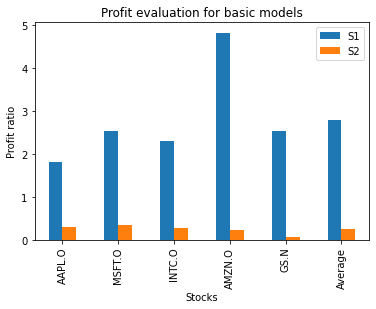

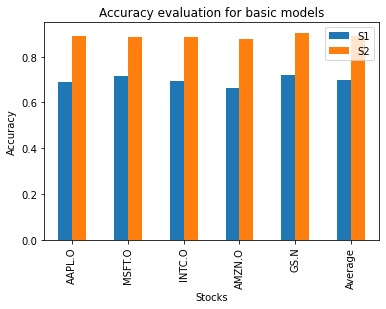

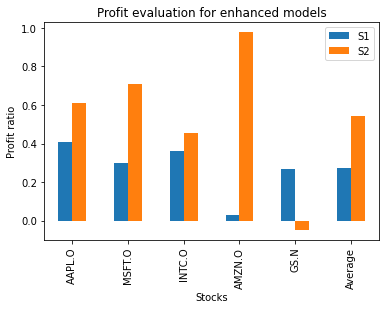

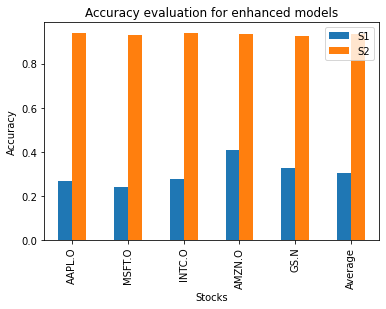

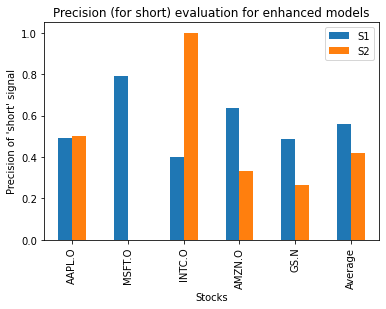

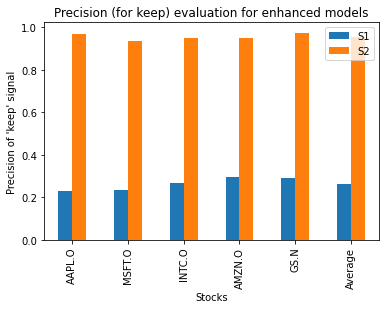

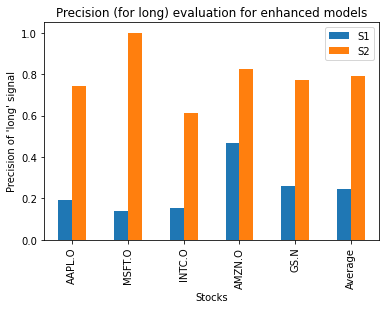

In [46]:
def merge_strats_met(s1, s2):
    """
    Merge two DataFrames representing different strategies' metrics and calculate the difference.

    Parameters:
    - s1 (pd.DataFrame): DataFrame representing metrics for strategy 1.
    - s2 (pd.DataFrame): DataFrame representing metrics for strategy 2.

    Returns:
    - merged (pd.DataFrame): Merged DataFrame containing metrics for both strategies.
    - diff (pd.DataFrame): DataFrame containing the difference between the two strategies' metrics.
    """
    diff = (s1 - s2)
    merged = s1.join(s2, lsuffix='_s1', rsuffix='_s2').sort_index(axis="columns", kind="stable")
    return merged, diff
                   
# Merge and calculate differences for basic model
merged_basic, d_basic = merge_strats_met(basic_met_df, basic_met_df2)
merged_basic_p, d_basic_p = merge_strats_met(basic_prec_df, basic_prec_df2)

# Merge and calculate differences for enhanced model
merged_enhanced, d_enhanced = merge_strats_met(enhanced_met_df, enhanced_met_df2)
merged_enhanced_p, d_enhanced_p = merge_strats_met(enhanced_prec_df, enhanced_prec_df2)

# Merge and calculate differences for performance
merged_performance, d_performance = merge_strats_met(performance_met_df, performance_met_df2)
merged_performance_p, d_performance_p = merge_strats_met(performance_prec_df, performance_prec_df2)

# Display the results
print('Merge statistics:')
print('\nBasic model:')
display(merged_basic)
print('\nPerformace evaluation between strategies (strat1 - strat 2):')
display(d_basic)
print('\nPrecision')
display(merged_basic_p)
print('\nPerformace evaluation between strategies (strat1 - strat 2) - precision:')
display(d_basic_p)

# Display the results for enhanced model
print('\n\nEnhanced model:')
display(merged_enhanced)
print('\nPerformace evaluation between strategies (strat1 - strat 2):')
display(d_enhanced)
print('\nPrecision')
display(merged_enhanced_p)
print('\nPerformace evaluation between strategies (strat1 - strat 2) - precision:')
display(d_enhanced_p)

# Display the results for performance model
print('\n\nPerformance model:')
display(merged_performance)
print('\nPerformace evaluation between strategies (strat1 - strat 2):')
display(d_performance)
print('\nPrecision')
display(merged_performance_p)
print('\nPerformace evaluation between strategies (strat1 - strat 2) - precision:')
display(d_performance_p)

# Plotting combined results for basic models
combined_profit_basic_c = pd.DataFrame(
    {'S1': basic_met_df.transpose()['Profit'],'S2': basic_met_df2.transpose()['Profit']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_profit_basic_c.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Profit ratio')
plt.title('Profit evaluation for basic models')

combined_accuracy_basic_c = pd.DataFrame(
    {'S1': basic_met_df.transpose()['Accuracy'],'S2': basic_met_df2.transpose()['Accuracy']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_accuracy_basic_c.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Accuracy')
plt.title('Accuracy evaluation for basic models')

# Plotting combined results for enhanced models
combined_profit_enhanced_c = pd.DataFrame(
    {'S1': enhanced_met_df.transpose()['Profit'],'S2': enhanced_met_df2.transpose()['Profit']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_profit_enhanced_c.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Profit ratio')
plt.title('Profit evaluation for enhanced models')

combined_accuracy_enhanced_c = pd.DataFrame(
    {'S1': enhanced_met_df.transpose()['Accuracy'],'S2': enhanced_met_df2.transpose()['Accuracy']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_accuracy_enhanced_c.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Accuracy')
plt.title('Accuracy evaluation for enhanced models')

# Plotting combined precision results for enhanced models
combined_precision_short = pd.DataFrame(
    {'S1': enhanced_prec_df.transpose()['short'],'S2': enhanced_prec_df2.transpose()['short']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_precision_short.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Precision of \'short\' signal')
plt.title('Precision (for short) evaluation for enhanced models')

combined_precision_keep = pd.DataFrame(
    {'S1': enhanced_prec_df.transpose()['keep'],'S2': enhanced_prec_df2.transpose()['keep']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_precision_keep.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Precision of \'keep\' signal')
plt.title('Precision (for keep) evaluation for enhanced models')

combined_precision_long = pd.DataFrame(
    {'S1': enhanced_prec_df.transpose()['long'],'S2': enhanced_prec_df2.transpose()['long']}, 
    index=['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'Average'])
combined_precision_long.plot.bar()
plt.xlabel('Stocks')
plt.ylabel('Precision of \'long\' signal')
plt.title('Precision (for long) evaluation for enhanced models')